In [1]:
import sys
import numpy as np
import pandas as pd
import pymongo
import bson
import json
import time
import datetime
import os
import collections
import random
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.summarization import keywords
import csv
import string
import re
import io
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from ast import literal_eval
import nltk
from nltk.corpus import stopwords
from collections import Counter
import gensim.downloader as api
import networkx as nx
import math
from tqdm import trange, tqdm
from symspellpy.symspellpy import SymSpell, Verbosity
from nltk import word_tokenize
nltk.download('stopwords')
from networkx.algorithms import community
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import igraph as ig
import louvain
import leidenalg
stopwords = nltk.corpus.stopwords.words('english')
import hdbscan
import torch
from transformers import AutoTokenizer, BertTokenizer, BertModel
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
import gensim
from gensim import corpora
import spacy
spacy.load('en')
from spacy.lang.en import English

[nltk_data] Downloading package stopwords to /home/abose/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-1-d451538fd330>:42: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


In [2]:
# contractions_save = json.dumps(contractions)
# file = open("/home/abose/Threat Intel/contractions_save.json","w")
# file.write(contractions_save)
# file.close()
with open('/home/abose/Threat Intel/contractions_save.json') as file:
    contractions = json.load(file)

In [3]:
def extend_doc(doc):
    tokens = doc.split()
    for idx, token in enumerate(tokens):
        if token in contractions:
            tokens[idx]=contractions[token]
    tokens = ' '.join(tokens)
    return tokens

In [4]:
def hook_compound(input_termList):
#     if not input_termList or input_termList == None or input_termList == "":
#         return input_termList
    # maximum edit distance per dictionary precalculation
    symSpell_1st_TotalTweetText=[]
    max_edit_distance_dictionary = 2
    prefix_length = 7
    # create object
    sym_spell = SymSpell(max_edit_distance_dictionary, prefix_length)
    # load dictionary
    dictionary_path = os.path.join(os.path.dirname("E:\\Threat_Intel_Research\\"),"frequency_dictionary_en_82_765.txt")
    term_index = 0  # column of the term in the dictionary text file
    count_index = 1  # column of the term frequency in the dictionary text file
    if not sym_spell.load_dictionary(dictionary_path, term_index, count_index):
        print("Dictionary file not found")
        return

    # max edit distance per lookup (per single word, not per whole input string)
    max_edit_distance_lookup = 2
    input_term2 = re.sub(r"http\S+", "", input_termList)
    suggestions = sym_spell.lookup_compound(input_term2, max_edit_distance_lookup)
    for suggestion in suggestions:
        symSpell_1st_TotalTweetText.append(suggestion.term)
 
    return symSpell_1st_TotalTweetText

In [5]:
def mainLookUp(input_termLookList):
#     if not input_termLookList or input_termLookList == None or input_termLookList == "":
#         return input_termLookList
    symSpell_2nd_TotalTweetText=[]
    # maximum edit distance per dictionary precalculation
    max_edit_distance_dictionary = 0
    prefix_length = 7
    # create object
    sym_spell = SymSpell(max_edit_distance_dictionary, prefix_length)
    # load dictionary
    dictionary_path = os.path.join(os.path.dirname("E:\\Threat_Intel_Research\\"),"frequency_dictionary_en_82_765.txt")
    term_index = 0  # column of the term in the dictionary text file
    count_index = 1  # column of the term frequency in the dictionary text file
    if not sym_spell.load_dictionary(dictionary_path, term_index, count_index):
        print("Dictionary file not found")
        return

    # a sentence without any spaces
    if input_termLookList:
        result = sym_spell.word_segmentation(input_termLookList)
        symSpell_2nd_TotalTweetText.append(result.corrected_string)
    return symSpell_2nd_TotalTweetText

In [6]:
def clean_doc(doc):
    # split into tokens by white space
    #doc = re.sub(r\"http\\S+\", \"\", doc)
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    #remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords)
    tokens = [w for w in tokens if not w in stop_words]
    #tokens = [stemmer.stem(t) for t in tokens]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [7]:
def process_text(text):
    text = extend_doc(text)
#     textSpell = hook_compound(text)
#     if len(textSpell[0])>=5:
#         textSpell = mainLookUp(textSpell[0])
#         cleanedText = clean_doc(textSpell[0])
    if len(text)>=5:
        cleanedText = clean_doc(text)
    else:
        cleanedText="NAAAN"
    return cleanedText

In [8]:
#define vectorizer parameters
def apply_TFIDF(fname):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.99,lowercase=True, max_features=200000,min_df=0.001, stop_words='english', use_idf=True)
    #check_mat=tfidf_vectorizer.fit(fname)
    #print("check ", check_mat.vocabulary_)
    tfidf_matrix = tfidf_vectorizer.fit_transform(fname) #fit the vectorizer to synopses
    #print(tfidf_matrix.shape, tfidf_matrix[0,0], tfidf_matrix[0,1], tfidf_matrix[0,2], tfidf_matrix[0,3])
    terms = tfidf_vectorizer.get_feature_names()
    #print(tfidf_matrix.shape, " + ",terms, tfidf_vectorizer.idf_)
    print(" + ", tfidf_matrix.shape, " + ")
    return tfidf_matrix

In [9]:
def userObjectDictionaryFunction():
    connection=pymongo.MongoClient()
    srcUserDB=connection.user_src_identification
    collection=srcUserDB.taggedData40k
    cursor=collection.find({},{"_id":0}).limit(40761)
    userObjectData=[]
    userIdDict=dict()
    for data in cursor:
        userDataDict=dict()
        for key, value in data.items():
            if key=="id":
                userID=value
            if key=="Description":
                userDataDict.update({"Description":value})
            if key=="DescTag":
                userDataDict.update({"DescTag":value})
            if key=="Followers":
                userDataDict.update({"Followers":value})
            if key=="Following":
                userDataDict.update({"Following":value})
            if key=="Tweets":
                userDataDict.update({"Tweets":value})
            if key=="TweetsTags":
                userDataDict.update({"TweetsTags":value})
            if key=="AllText":
                userDataDict.update({"AllText":value})
            if key=="AllTextTags":
                userDataDict.update({"AllTextTags":value})
        userIdDict.update({int(userID):userDataDict})
    return userIdDict
userIdDict = userObjectDictionaryFunction()

In [10]:
len(userIdDict)

40761

In [11]:
######## Only For Validation #########
validation_DF = pd.read_json("annotated_smallNetwork.json", lines=True)
validation_DF.head(5)

,id,Description,DescTag,Tweets,TweetsTags,AllText,AllTextTags,Followers,Following,Annotation
0,1161296115637084162,#Spider Overlord calling #darknet home. Talk #...,[/technology and computing/hardware/computer c...,[A wild sponsor appears! Two more bundles hat...,"[[/style and fashion/luxury goods, /pets/large...",A wild sponsor appears! Two more bundles hath...,"[/art and entertainment/movies and tv/movies, ...","[1112062964260110336, 985304744146202624, 1304...","[347191988, 1302055132822110209, 14727747, 330...",relevant
1,1112062964260110336,🍣 researcher 🦕 pentester 😈 web monkey 🙊 datteb...,[/technology and computing/internet technology...,[Perhaps currently I 'm going through the most...,"[[/society/unrest and war, /art and entertainm...",@alicanact60 @Hacker0x01 👍👍👍👍👍@SecGoblin @root...,"[/technology and computing/hardware, /technolo...","[1229142485823315968, 28482605, 773838475]","[1145546584752394241, 1235115096528936960, 220...",irrelevant
2,985304744146202624,bebe gay III 🏳️‍🌈 ه҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈...,[/society/gay life],[],[],bebe gay III 🏳️‍🌈 ه҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈...,[/society/gay life],[],[],irrelevant
3,861889353869557762,"Hi, it's me // SEO Class of 2008 // Autodidact...",[/technology and computing/internet technology...,[Airbnb markets are crazy right now https://t....,"[[/travel/vacation rentals, /finance/investing...",Airbnb markets are crazy right now https://t.c...,"[/food and drink/vegetarian, /food and drink/v...","[1026799219716177920, 1134088559617630208, 117...","[22589449, 2707742660, 1099713672434335744]",irrelevant
4,733074959338213379,Cybersecurity is a ILLUSION,"[/technology and computing/computer security, ...",[],[],Cybersecurity is a ILLUSION,"[/technology and computing/computer crime, /te...",[],[],relevant


In [12]:
countDict = Counter(validation_DF['Annotation'])
recall_base = countDict['relevant']

Name: 
Type: DiGraph
Number of nodes: 938
Number of edges: 964
Average in degree:   1.0277
Average out degree:   1.0277


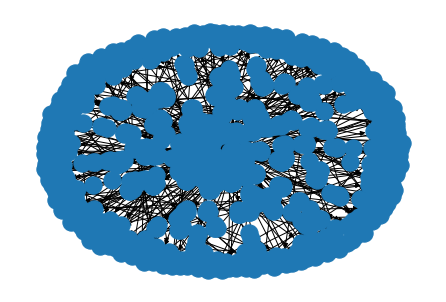

In [13]:
######## Only For Validation #########
val_FollowerNode = list()
val_FollowingNode = list()
val_follow_count_mapper = dict()
nodeId_Set= set(validation_DF['id'])
for index, DataRow in validation_DF.iterrows():
    if 'Followers' in DataRow:
        if DataRow['id'] in userIdDict:
            val_follow_count_mapper[DataRow['id']] = len(userIdDict[DataRow['id']]['Followers'])
        else:
            val_follow_count_mapper[DataRow['id']] = len(DataRow['Followers'])
#         for val_followerKey, val_follower in enumerate(literal_eval(DataRow['Followers'])):
        for val_followerKey, val_follower in enumerate(DataRow['Followers']):
            if val_follower in nodeId_Set:
                val_FollowerNode.append((int(DataRow['id']), int(val_follower), 1))
    if 'Following' in DataRow:
        if DataRow['id'] in userIdDict:
            val_follow_count_mapper[DataRow['id']] = val_follow_count_mapper[DataRow['id']] + len(userIdDict[DataRow['id']]['Following'])
        else:
            val_follow_count_mapper[DataRow['id']] =  val_follow_count_mapper[DataRow['id']] + len(DataRow['Following'])
#         for val_followingKey, val_following in enumerate(literal_eval(DataRow['Following'])):
        for val_followingKey, val_following in enumerate(DataRow['Following']):
            if val_following in nodeId_Set:
                val_FollowingNode.append((int(val_following), int(DataRow['id']), 1))
            
val_FollowerDF = pd.DataFrame(val_FollowerNode, columns =['Src', 'Des', 'Score'])
val_FollowingDF= pd.DataFrame(val_FollowingNode, columns = ['Src', 'Des', 'Score'])
val_FollowDF = pd.concat([val_FollowerDF,val_FollowingDF])
val_FollowDF.to_csv("val_FollowDF.csv", sep=',', index=False, header=False)
val_nx_graph=nx.read_edgelist('val_FollowDF.csv', delimiter=',', data=(('weight',float),), nodetype=int, create_using=nx.DiGraph())
print(nx.info(val_nx_graph))
nx.draw(val_nx_graph)
plt.show()

### Only For Validation ####

In [14]:
valid_userIdDict = {nodeID:userIdDict[nodeID] for nodeID in nodeId_Set if nodeID in userIdDict}
userIdDict = valid_userIdDict

### First Baseline method execution starts from here

In [15]:
# MPopular_baseLine = [{k: v} for k, v in sorted(val_follow_count_mapper.items(), key=lambda item: item[1])][-50:]

### First Baseline method execution ends here

In [16]:
# print(len(userIdDict.keys()), len(nodeId_Set), userIdDict.keys())
# print(val_follow_count_mapper)
len(list(userIdDict.values()))

937

In [17]:
def create_Json_Processed_Data_File():
    for userID, entries in userIdDict.items():
        processedTweetTextList = list()
        if "Tweets" in entries:
            if len(entries["Tweets"]) != 0:
                for tweetText in entries["Tweets"]:
                    if len(tweetText) <= 5:
                        continue
                    else:
                        processedTweetTextList.append(process_text(tweetText))
                entries.update({"Tweets":processedTweetTextList})
            else:
                del entries["Tweets"]
        if "AllText" in entries:
            if len(entries["AllText"]) >= 5:
                entries.update({"AllText":process_text(entries["AllText"])})
            elif "Tweets" in entries and len(entries["AllText"]) < 5 and len(entries["Tweets"]) >= 2:
                entries.update({"AllText":' '.join(processedTweetTextList)})
            else:
                del entries["AllText"]
        if "Description" in entries:
            if len(entries["Description"]) >= 5:
                entries.update({"Description":process_text(entries["Description"])})
            else:
                del entries["Description"]
        if 'DescTag' in entries:
            if len(entries['DescTag']) == 0:
                del entries['DescTag']
    with open('userIdDict.json', 'w') as fp:
        json.dump(userIdDict, fp)
create_Json_Processed_Data_File()

### The following code block assigns score to a twitter account based on the IBM watson tagging and helps removing twitter account from the analysis if the account is not relevant ###

In [18]:
def categoryAnalyzer(tweetID, Type):
    userScoreDict=dict()
    score=0
    keepOrDiscard=True
    if tweetID not in userIdDict:
        userScoreDict[tweetID] = 0
        keepOrDiscard = False
        return keepOrDiscard, userScoreDict
    if "TweetsTags" not in userIdDict[tweetID] and "DescTag" not in userIdDict[tweetID]:
        userScoreDict[tweetID] = 0
        keepOrDiscard = False
        return keepOrDiscard, userScoreDict
    if "TweetsTags" in userIdDict[tweetID] and Type==True:
        countTech=0
        countSci=0
        for per_TextID, categoryList in enumerate(userIdDict[tweetID]["TweetsTags"]):
            for tagID, category in enumerate(categoryList):
                if "antivirus and malware" in category:
                    score=score+1
                    break
                if "technology and computing" in category:
                    if (countTech%5)==0:
                        score=score+0.5
                    countTech=countTech+1
                    break
                if "computer science" in category:
                    if (countSci%5)==0:
                        score=score+0.1
                    countSci=countSci+1
        if countTech<=2:
            userScoreDict[tweetID] = 0
            keepOrDiscard = False
    if "DescTag" in userIdDict[tweetID] and Type==True:
        for tagID, category in enumerate(userIdDict[tweetID]["DescTag"]):
            if "technology and computing" in category:
                score=score+2
                break
            if "computer science" in category:
                score=score+0.5
    if keepOrDiscard==True:
        userScoreDict[tweetID] = score
#     else:
#         print("Assign 0")
    return keepOrDiscard, userScoreDict

In [19]:
# categoryAnalyzer(1006326206579511296, True)
# userIdDict[222405719]

### Only need for main data execution

In [20]:
# followerNode=list()
# followingNode=list()
# for key, item in userIdDict.items():
#     if 'Followers' in item:
#         for follrKey, followerVal in enumerate(item['Followers']):
#             followerNode.append((int(key), int(followerVal), 1.00))
#     if 'Following' in item:
#         for follngKey, followingVal in enumerate(item['Following']):
#             followingNode.append((int(followingVal), int(key), 1.00))

### Only need for main data execution

In [21]:
# followerDF = pd.DataFrame(followerNode, columns =['Src', 'Des', 'Score'])
# followingDF= pd.DataFrame(followingNode, columns = ['Src', 'Des', 'Score'])
# followRelnDF = pd.concat([followerDF,followingDF])
# followerDF.to_csv("followerDF.csv", sep=',', index=False, header=False)
# followingDF.to_csv("followingDF.csv", sep=',', index=False, header=False)
# followRelnDF.to_csv("followRelnDF.csv", sep=',', index=False, header=False)

### Only need for main data execution

In [22]:
# def graph_reader():
#     """
#     Function to read the graph from the path.
#     :param path: Path to the edge list.
#     :return graph: NetworkX object returned.
#     """
#     graph=nx.read_edgelist('followRelnDF.csv', delimiter=',', data=(('weight',float),), nodetype=int, create_using=nx.DiGraph())
#     graph1=nx.read_edgelist('followerDF.csv', delimiter=',', data=(('weight',float),), nodetype=int, create_using=nx.DiGraph())
#     graph2=nx.read_edgelist('followingDF.csv', delimiter=',', data=(('weight',float),), nodetype=int, create_using=nx.DiGraph())
#     return graph, graph1, graph2

### Only need for main data execution

In [23]:
# nx_graph, graph1, graph2 = graph_reader()
# nx_graph.edges()

In [24]:
# nx_graph.nodes()
# print(nx.info(nx_graph))
# nx.draw(nx_graph)
# plt.show()

### Only For Validation ###

In [25]:
nx_graph = val_nx_graph

## Community Detection using Girvan-Newman Algorithm 

In [26]:
# communities_generator = community.girvan_newman(nx_graph)
# top_level_communities = next(communities_generator)
# next_level_communities = next(communities_generator)
# sorted(map(sorted, next_level_communities))

In [27]:
# testList = sorted(map(sorted, next_level_communities))
# len(testList)

In [28]:
# girvan_PartitionDict=dict()
# for idx, subGrList in enumerate(testList):
#     for ind, node in enumerate(subGrList):
#         girvan_PartitionDict.update({node:idx})
        
        
        
        
        
        
# pos = nx.spring_layout(nx_graph)
# cmap = cm.get_cmap('viridis', max(girvan_PartitionDict.values()) + 1)
# nx.draw_networkx_nodes(nx_graph, pos, girvan_PartitionDict.keys(), node_size=40, cmap=cmap, node_color=list(girvan_PartitionDict.values()))
# nx.draw_networkx_edges(nx_graph, pos, alpha=0.5)
# plt.show()

## Community Detection on Leiden Algorithm (Networkx+igraph)

In [29]:
nxNode_to_Index_Mapping = {node:ind for ind, node in enumerate(list(nx_graph.nodes()))}
index_to_nxNode_Mapping = {ind:node for ind, node in enumerate(list(nx_graph.nodes()))}
nxNodeList = list(index_to_nxNode_Mapping.keys())
mapped_Edgelist = [(nxNode_to_Index_Mapping[nodeTouple[0]], nxNode_to_Index_Mapping[nodeTouple[1]]) for nodeTouple in nx_graph.edges()]
ig_graph = ig.Graph(len(nx_graph), mapped_Edgelist)
# ig_graph = ig.Graph.Adjacency((nx.to_scipy_sparse_matrix(nx_graph) > 0).tolist())
louvain_partition = louvain.find_partition(ig_graph, louvain.ModularityVertexPartition)
leiden_partition = leidenalg.find_partition(ig_graph, leidenalg.ModularityVertexPartition)

In [30]:
edgeList=ig_graph.get_edgelist()
nx_conv_graph = nx.DiGraph(edgeList)

In [31]:
leiden_partitionDict= dict()
for ind, nodeList in enumerate(list(leiden_partition)):
    for node in nodeList:
        leiden_partitionDict.update({node:ind})

In [32]:
def community_user_membership_function():
    communityScoreDict=dict()
    allUserScoreDict = dict()
    communityTextDict=dict()
    igraph_nx_mapper = dict()
    valid_UserNodes_in_Community = dict()
    userNode_Community_map = dict()
    for commID, community in enumerate(leiden_partition):
#         nxNodeList = list(nx_graph.nodes())
        communityTotalScore=0
        communityText = ""
        CTI_userList=list()
        for index, memberNode in enumerate(community):
            igraph_nx_mapper.update({memberNode:index_to_nxNode_Mapping[nxNodeList[memberNode]]})
            
            status, id_with_Score = categoryAnalyzer(index_to_nxNode_Mapping[nxNodeList[memberNode]], True)
            
#             status, id_with_Score = categoryAnalyzer(nxNodeList[memberNode], True)
            
            communityTotalScore = communityTotalScore + list(id_with_Score.values())[0]
            allUserScoreDict.update(id_with_Score)
            if status == True:
                if userIdDict[index_to_nxNode_Mapping[nxNodeList[memberNode]]]['Tweets'] and userIdDict[index_to_nxNode_Mapping[nxNodeList[memberNode]]]['Tweets'] != None:
                    Tweets=' '.join(userIdDict[index_to_nxNode_Mapping[nxNodeList[memberNode]]]['Tweets'])
                    communityText = communityText + " " + Tweets
                    CTI_userList.append(index_to_nxNode_Mapping[nxNodeList[memberNode]])
                    userNode_Community_map.update({index_to_nxNode_Mapping[nxNodeList[memberNode]]:commID})
        communityScoreDict[commID] = communityTotalScore/(len(community))
        valid_UserNodes_in_Community[commID] = CTI_userList
    #     print("communityScoreDict-> ", communityScoreDict[commID], communityText)
        if communityText or communityText != "":
            communityTextDict.update({commID:communityText})
    return communityScoreDict, allUserScoreDict, communityTextDict, igraph_nx_mapper, valid_UserNodes_in_Community, userNode_Community_map

In [33]:
def seedInput(seedList):
    seedNode_CleanedTextList =  list()
    for idx, nodeID in enumerate(seedList):
        if nodeID in userIdDict.keys():
            userObject = userIdDict[seedList[idx]]
            if 'AllText' in userObject and userObject['AllText'] != None and len(userObject['AllText'])>= 0:
                seedNode_CleanedTextList.append(userObject['AllText'])
    return seedNode_CleanedTextList

In [34]:
#seed node input
def text_tfIdf_Vectorization(commOrUser_TextDict_or_TextList, seed_TextList):
    if isinstance(commOrUser_TextDict_or_TextList, dict):
        sparse_tfIdfVector = apply_TFIDF(list(commOrUser_TextDict_or_TextList.values()) + seed_TextList)
    if isinstance(commOrUser_TextDict_or_TextList, list):
        sparse_tfIdfVector = apply_TFIDF(commOrUser_TextDict_or_TextList + seed_TextList)
    return sparse_tfIdfVector

In [35]:
def similarty_Calculation_and_MaxSimilar_Community_or_Node_retrieval(seed_sparse_tfIdfVector, index_to_entity_Mapper, seedList, val):
    if val == True:
        selection = 50
    else:
        selection = 4
    seed_sparse_tfIdfVector = seed_sparse_tfIdfVector.toarray()
    similarityMatrix = cosine_similarity(seed_sparse_tfIdfVector[-len(seedList):],seed_sparse_tfIdfVector[0:(seed_sparse_tfIdfVector.shape[0]-len(seedList))])
    MaxSimilartyList = [list(similarityMatrix[i].argsort()[-selection:][::-1]) for i in range(similarityMatrix.shape[0])]
    entitySimScore = np.array([np.take(similarityMatrix[i], indices, axis=0) for i, indices in enumerate(MaxSimilartyList)])
#     print("MaxSimilartyList-> ", MaxSimilartyList)
    entityID = set([index_to_entity_Mapper[y] for x in MaxSimilartyList for y in x])
    return similarityMatrix, MaxSimilartyList, entityID, entitySimScore

##### Second baseline Code Starts here

In [36]:
def friend_of_friend_generator(feed_List_Set):
    feed_List_Set = list(feed_List_Set)
    FoF_baseline = list()
#     print(feed_List_Set)
    for feedNode in feed_List_Set:
        if feedNode in userIdDict:
            if 'Followers' in userIdDict[feedNode]:
                FoF_baseline.extend(set(userIdDict[feedNode]['Followers']))
    return FoF_baseline

In [37]:
def fof_driver(FoF_baseline):
    # rangeValue = int(input("Number of Iteration"))
    rangeValue = 2
    for i in range(rangeValue):
        FoF_baseline = friend_of_friend_generator(FoF_baseline)
        FoF_baseline = {fol_1 for fol_1 in FoF_baseline if fol_1 in set(validation_DF['id'])}
#     print(len(FoF_baseline))
    return FoF_baseline

##### Second baseline Code Ends

#### Third baseline Code Starts here

In [38]:
def third_baseline_function(seedNode_CleanedTextList, FoF_baseline):    
    id_AllText_mapper = {tID: tVal['AllText'] for tID, tVal in userIdDict.items() if 'AllText' in tVal}
    thirdBase_userID_to_Index_Mapper = {node: i for i, node in enumerate(list(id_AllText_mapper.keys()))}
    index_to_thirdBase_userID_Mapper = {i: node for i, node in enumerate(list(thirdBase_userID_to_Index_Mapper.keys()))}
    CplusL_tfIdfVector = text_tfIdf_Vectorization(id_AllText_mapper, seedNode_CleanedTextList)
    val_similarityMatrix, val_MaxSimilartyList, val_userID, val_userSimScore = similarty_Calculation_and_MaxSimilar_Community_or_Node_retrieval(CplusL_tfIdfVector, index_to_thirdBase_userID_Mapper, FoF_baseline, True)
    CplusL_baseline = set(FoF_baseline).intersection(set(val_userID))
    return CplusL_baseline

#### Third baseline Code Ends here

In [39]:
def community_total_score_calculation(communityTextDict, seedNode_CleanedTextList, communityScoreDict, index_to_Community_Mapper, seedList, alpha):    
    community_seed_sparse_tfIdfVector = text_tfIdf_Vectorization(communityTextDict, seedNode_CleanedTextList)
    similarityMatrix, MaxSimilartyList, communityID, communitySimScore = similarty_Calculation_and_MaxSimilar_Community_or_Node_retrieval(community_seed_sparse_tfIdfVector, index_to_Community_Mapper, seedList, False)
    # method = str(input("Seperate or All"))
    method = "Sep"
    if method =="Sep":
#         print(MaxSimilartyList,communitySimScore)
        communityWeight = np.array([np.array([communityScoreDict[index_to_Community_Mapper[y]] for y in x]) for x in MaxSimilartyList])
        value = np.add(communitySimScore*alpha, communityWeight)
    #     print(value, communityWeight)
    if method == "All":
        #     MaxSimilartyArray = set(itertools.chain.from_iterable(MaxSimilartyList))
        communitySimScoreFlat = communitySimScore.flatten('C')
        print(MaxSimilartyList,communitySimScore, communitySimScoreFlat)
        communityWeightFlat = np.array([communityScoreDict[index_to_Community_Mapper[y]] for x in MaxSimilartyList for y in x])
        value = np.add(communitySimScoreFlat, communityWeightFlat)
    #     print(value, communityWeight)
    
    return communityID

In [40]:
def user_Search_in_Community(valid_UserNodes, seed_TextList, communityID, allUserScoreDict, seedList, alpha):
    user_Score_in_CommunityDict = dict()
    for commKey in communityID:
        usrID_score_dict = dict()
        if commKey in valid_UserNodes:
            community_Member_TextList = [userIdDict[userID]['AllText'] for userID in valid_UserNodes[commKey]]
            userNode_seed_sparse_tfIdfVector = text_tfIdf_Vectorization(community_Member_TextList, seed_TextList)
            userNode_seed_sparse_tfIdfVector = userNode_seed_sparse_tfIdfVector.toarray()
#             print("userNode_seed_sparse_tfIdfVector-> ", userNode_seed_sparse_tfIdfVector.shape)
            user_Seed_SimilarityMatrix = cosine_similarity(userNode_seed_sparse_tfIdfVector[-len(seedList):],userNode_seed_sparse_tfIdfVector[0:(userNode_seed_sparse_tfIdfVector.shape[0]-len(seedList))])
#             print("#########", user_Seed_SimilarityMatrix)
            if user_Seed_SimilarityMatrix.shape[1] <= 1:
                user_Seed_MaxSimilartyArr = np.array([np.zeros(len(user_Seed_SimilarityMatrix.flatten()))])
                userNode_SimScore = np.array(user_Seed_SimilarityMatrix).flatten()
            else:
                user_Seed_MaxSimilartyArr = np.array([user_Seed_SimilarityMatrix[i].argsort()[-3:][::-1] for i in range(user_Seed_SimilarityMatrix.shape[0])])
                ### Problem
                userNode_SimScore = np.array([np.take(user_Seed_SimilarityMatrix[i], list(user_Seed_MaxSimilartyArr[i,:]), axis=0) for i in range(user_Seed_MaxSimilartyArr.shape[0])])
            user_Seed_MaxSimilartyArrFlat = user_Seed_MaxSimilartyArr.flatten('C')
            userNode_SimScoreFlat = userNode_SimScore.flatten('C')
            print("commKey-> ", commKey, " user_Seed_MaxSimilartyArrFlat-> ", len(user_Seed_MaxSimilartyArrFlat), user_Seed_MaxSimilartyArrFlat)
            userNodeID = [valid_UserNodes[commKey][int(x)] for x in np.nditer(user_Seed_MaxSimilartyArrFlat)]
            userNode_Weight = np.array([allUserScoreDict[y] for y in userNodeID])
            userNode_Score_Array = np.add(userNode_SimScoreFlat*alpha, userNode_Weight)
#             print("user_Seed_MaxSimilartyArr-> ", user_Seed_MaxSimilartyArr," userNode_SimScoreFlat-> ",userNode_SimScoreFlat," userNode_Weight-> ", userNode_Weight)
            for idx, nodeID in enumerate(userNodeID):
                if nodeID in usrID_score_dict:
                    if usrID_score_dict[nodeID]> userNode_Score_Array[idx]:
                        continue
                    else:
                        usrID_score_dict[nodeID] = userNode_Score_Array[idx]
                else:
                    usrID_score_dict[nodeID] = userNode_Score_Array[idx]
            user_Score_in_CommunityDict[commKey] = usrID_score_dict
    return user_Score_in_CommunityDict

In [41]:
def sort_recommended_userNodes(recommended_UserIDwith_Score):
    userID_Score_tempList=list()
    for community_ID_Score_val_dict in recommended_UserIDwith_Score.values():
        for key, val in community_ID_Score_val_dict.items():
            userID_Score_tempList.append({key:val})
    recommended_UserIDwith_Score = sorted(userID_Score_tempList, key = lambda i: list(i.values()), reverse=True)[:30]
    print(len(recommended_UserIDwith_Score),recommended_UserIDwith_Score)
    return recommended_UserIDwith_Score

In [42]:
# The following two lines Can be added
def add_adaptive_weight_for_highRank_node_community(recommended_UserIDwith_Score, userNode_Community_map, valid_UserNodes_in_Community):
    highRank_Comm_User_map_list = [{(userNode_Community_map[list(id_value_map.keys())[0]]):(list(id_value_map.keys())[0])} for id_value_map in recommended_UserIDwith_Score]
    community_flag = set()
    for commID_usr_map in highRank_Comm_User_map_list:
        if list(commID_usr_map.keys())[0] in community_flag:
            continue
        else:
            community_flag.add(list(commID_usr_map.keys())[0])

            for usrID in valid_UserNodes_in_Community[list(commID_usr_map.keys())[0]]:
                if usrID == list(commID_usr_map.values())[0]:
                    continue
                if usrID in recommended_UserIDwith_Score and usrID != list(commID_usr_map.values())[0]:
                    recommended_UserIDwith_Score[usrID] = recommended_UserIDwith_Score[usrID] + recommended_UserIDwith_Score[list(commID_usr_map.values())[0]]*0.2
    return recommended_UserIDwith_Score

# Model Validation Part #

In [43]:
def model_performance_exhibition(recommended_UserIDwith_Score, withScore):
    resultList = list()
    if withScore:
        userID = [list(id_score.keys())[0] for id_score in recommended_UserIDwith_Score]
    if not withScore:
        userID = recommended_UserIDwith_Score
    for valID in userID:
        resultList.append(validation_DF.iloc[validation_DF[validation_DF['id'] == valID].index.tolist()[0]]['Annotation'])
#         print(validation_DF.iloc[validation_DF[validation_DF['id'] == valID].index.tolist()[0]]['Annotation'])
    return resultList

In [44]:
def adaptive_precision(resultList):
    countDict = Counter(resultList) 
    precision = countDict['relevant']/len(resultList)
    return precision

In [45]:
def adaptive_recall(resultList):
    countDict = Counter(resultList) 
    recall = countDict['relevant']/recall_base
    return recall

In [46]:
def adaptive_F1score(precision, recall):
    beta = 0.5
    f1_Score = ((1 + beta*beta)*(precision*recall))/(((beta*beta)*precision) + recall)
    return f1_Score

In [47]:
# def model_comparison_result(recommended_UserIDwith_Score, MPopular_baseLine, FoF_baseline, CplusL_baseline):
def model_comparison_result(recommended_UserIDwith_Score, FoF_baseline, CplusL_baseline):
    ### Proposed Model
    prposed_resultList = model_performance_exhibition(recommended_UserIDwith_Score, True) ## Proposed model
    proposed_precision = adaptive_precision(prposed_resultList)
    proposed_recall = adaptive_recall(prposed_resultList)
    proposed_f1_Score = adaptive_F1score(proposed_precision, proposed_recall)
    print("Proposed-> ", "f1_Score-> ", adaptive_F1score(proposed_precision, proposed_recall), "precision-> ", proposed_precision, "recall-> ", proposed_recall)
    
    ### First Baseline
#     first_baseline_resultList = model_performance_exhibition(MPopular_baseLine, True)
#     first_baseline_precision = adaptive_precision(first_baseline_resultList)
#     first_baseline_recall = adaptive_recall(first_baseline_resultList)
#     first_baseline_f1_Score = adaptive_F1score(first_baseline_precision, first_baseline_recall)
#     print("first_baseline-> ", "f1_Score-> ", adaptive_F1score(first_baseline_precision, first_baseline_recall), "precision-> ", first_baseline_precision, "recall-> ", first_baseline_recall)
    
    ### Second Baseline
    second_baseline_resultList = model_performance_exhibition(list(FoF_baseline), False)
    second_baseline_precision = adaptive_precision(second_baseline_resultList)
    second_baseline_recall = adaptive_recall(second_baseline_resultList)
    second_baseline_f1_Score = adaptive_F1score(second_baseline_precision, second_baseline_recall)
    print("second_baseline-> ", "f1_Score-> ", adaptive_F1score(second_baseline_precision, second_baseline_recall), "precision-> ", second_baseline_precision, "recall-> ", second_baseline_recall)
    
    ### Third Baseline
    third_baseline_resultList = model_performance_exhibition(list(CplusL_baseline), False)
    third_baseline_precision = adaptive_precision(third_baseline_resultList)
    third_baseline_recall = adaptive_recall(third_baseline_resultList)
    third_baseline_f1_Score = adaptive_F1score(third_baseline_precision, third_baseline_recall)
    print("third_baseline-> ", "f1_Score-> ", adaptive_F1score(third_baseline_precision, third_baseline_recall), "precision-> ", third_baseline_precision, "recall-> ", third_baseline_recall)
    
    return proposed_precision, proposed_recall, proposed_f1_Score, second_baseline_precision, second_baseline_recall, second_baseline_f1_Score, third_baseline_precision, third_baseline_recall, third_baseline_f1_Score
#     return proposed_precision, proposed_recall, proposed_f1_Score, first_baseline_precision, first_baseline_recall, first_baseline_f1_Score, second_baseline_precision, second_baseline_recall, second_baseline_f1_Score, third_baseline_precision, third_baseline_recall, third_baseline_f1_Score

In [48]:
def driver_function(seedList, alpha):
    communityScoreDict, allUserScoreDict, communityTextDict, igraph_nx_mapper, valid_UserNodes_in_Community, userNode_Community_map = community_user_membership_function()
    community_to_Index_Mapper = {node: i for i, node in enumerate(list(communityTextDict.keys()))}
    index_to_Community_Mapper = {i: node for i, node in enumerate(list(community_to_Index_Mapper.keys()))}
    seedNode_CleanedTextList = seedInput(seedList)
    communityID = community_total_score_calculation(communityTextDict, seedNode_CleanedTextList, communityScoreDict, index_to_Community_Mapper, seedList, alpha)
    recommended_UserIDwith_Score = user_Search_in_Community(valid_UserNodes_in_Community, seedNode_CleanedTextList, communityID, allUserScoreDict, seedList, alpha)
    recommended_UserIDwith_Score = sort_recommended_userNodes(recommended_UserIDwith_Score)
    recommended_UserIDwith_Score = add_adaptive_weight_for_highRank_node_community(recommended_UserIDwith_Score, userNode_Community_map, valid_UserNodes_in_Community)
    return recommended_UserIDwith_Score

In [ ]:
list_of_seedList = [[835035547, 1102643178,1927923236], [98210594, 14945996, 14666934], [609536134, 37771774, 42920448]]
# seedList = [97721735,398400323, 459375780] # Never
# seedList = [2730681163, 558033985, 272760181, 2283961765]
selection_Threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
alpha = 1
avg_prop_preList = list()
avg_prop_recList = list()
avg_prop_f1List = list()

avg_secondB_preList = list()
avg_secondB_recList = list()
avg_secondB_f1List = list()

avg_thirdB_preList = list()
avg_thirdB_recList = list()
avg_thirdB_f1List = list()

for seedList in list_of_seedList:
    FoF_baseline = seedList.copy()
    recommended_UserIDwith_Score = driver_function(seedList.copy(), alpha)
    FoF_baseline = fof_driver(FoF_baseline)
    seedNode_CleanedTextList = seedInput(seedList.copy())
    CplusL_baseline = third_baseline_function(seedNode_CleanedTextList, FoF_baseline)
    temp_proposed = recommended_UserIDwith_Score.copy()
    temp_2nd_baseline = FoF_baseline.copy()
    temp_3rd_baseline = CplusL_baseline.copy()
    prop_preList = list()
    prop_recList = list()
    prop_f1List = list()
#     firstB_preList = list()
#     firstB_recList = list()
#     firstB_f1List = list()
    secondB_preList = list()
    secondB_recList = list()
    secondB_f1List = list()
    thirdB_preList =  list()
    thirdB_recList = list()
    thirdB_f1List = list()
    for threshold in selection_Threshold:
        recommended_UserIDwith_Score = temp_proposed
        FoF_baseline = temp_2nd_baseline
        CplusL_baseline = temp_3rd_baseline
        for i in range(5):
            recommended_UserIDwith_Score = [list(id_score.keys())[0] for id_score in recommended_UserIDwith_Score]
            recommended_UserIDwith_Score = recommended_UserIDwith_Score[0:math.ceil(len(recommended_UserIDwith_Score)*threshold)]
            recommended_UserIDwith_Score = driver_function(recommended_UserIDwith_Score, alpha)
            
            FoF_baseline = list(FoF_baseline)[0:math.ceil(len(FoF_baseline)*threshold)]
            FoF_baseline = fof_driver(FoF_baseline)
            
            
            CplusL_baseline = list(CplusL_baseline)[0:math.ceil(len(CplusL_baseline)*threshold)]
            feedNode_TextList = seedInput(CplusL_baseline)
            CplusL_baseline = third_baseline_function(feedNode_TextList, FoF_baseline)
            
        proposed_precision, proposed_recall, proposed_f1_Score, second_baseline_precision, second_baseline_recall, second_baseline_f1_Score, third_baseline_precision, third_baseline_recall, third_baseline_f1_Score = model_comparison_result(recommended_UserIDwith_Score, FoF_baseline, CplusL_baseline)
#         proposed_precision, proposed_recall, proposed_f1_Score, first_baseline_precision, first_baseline_recall, first_baseline_f1_Score, second_baseline_precision, second_baseline_recall, second_baseline_f1_Score, third_baseline_precision, third_baseline_recall, third_baseline_f1_Score = model_comparison_result(recommended_UserIDwith_Score, MPopular_baseLine, FoF_baseline, CplusL_baseline)
        prop_preList.append(proposed_precision)
        prop_recList.append(proposed_recall)
        prop_f1List.append(proposed_f1_Score)
#         firstB_preList.append(first_baseline_precision)
#         firstB_recList.append(first_baseline_recall)
#         firstB_f1List.append(first_baseline_f1_Score)
        secondB_preList.append(second_baseline_precision)
        secondB_recList.append(second_baseline_recall)
        secondB_f1List.append(second_baseline_f1_Score)
        thirdB_preList.append(third_baseline_precision)
        thirdB_recList.append(third_baseline_recall)
        thirdB_f1List.append(third_baseline_f1_Score)
    
    avg_prop_preList.append(prop_preList)
    avg_prop_recList.append(prop_recList)
    avg_prop_f1List.append(prop_f1List)
    avg_secondB_preList.append(secondB_preList)
    avg_secondB_recList.append(secondB_recList)
    avg_secondB_f1List.append(secondB_f1List)
    avg_thirdB_preList.append(thirdB_preList)
    avg_thirdB_recList.append(thirdB_recList)
    avg_thirdB_f1List.append(thirdB_f1List)

 +  (116, 51148)  + 
 +  (23, 4279)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  9 [13 19 18 10  8  1 11 19 15]
 +  (9, 1757)  + 
commKey->  37  user_Seed_MaxSimilartyArrFlat->  9 [5 0 3 2 0 3 0 4 2]
 +  (15, 2802)  + 
commKey->  7  user_Seed_MaxSimilartyArrFlat->  9 [ 3 10  6 10  2  3  8  5  9]
 +  (9, 2136)  + 
commKey->  71  user_Seed_MaxSimilartyArrFlat->  9 [3 0 2 0 5 4 0 2 4]
 +  (8, 1562)  + 
commKey->  103  user_Seed_MaxSimilartyArrFlat->  9 [0 2 3 0 2 3 2 0 3]
 +  (8, 1776)  + 
commKey->  73  user_Seed_MaxSimilartyArrFlat->  9 [3 4 0 4 3 1 0 4 3]
 +  (9, 1852)  + 
commKey->  109  user_Seed_MaxSimilartyArrFlat->  9 [0 4 5 0 4 2 3 5 1]
 +  (10, 1943)  + 
commKey->  83  user_Seed_MaxSimilartyArrFlat->  9 [4 0 6 0 6 5 1 0 6]
 +  (10, 2099)  + 
commKey->  88  user_Seed_MaxSimilartyArrFlat->  9 [5 1 6 5 4 0 6 0 4]
 +  (9, 1932)  + 
commKey->  57  user_Seed_MaxSimilartyArrFlat->  9 [3 0 4 4 2 1 0 1 3]
 +  (6, 1417)  + 
commKey->  92  user_Seed_MaxSimilartyArrFlat->  9 [1 0 2 0 

 +  (919, 61163)  + 
 +  (116, 51160)  + 
 +  (9, 1756)  + 
commKey->  34  user_Seed_MaxSimilartyArrFlat->  9 [5 0 3 5 4 2 2 5 4]
 +  (19, 3342)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  9 [ 3 14  6  3 15  6 15  3 14]
 +  (9, 1935)  + 
commKey->  71  user_Seed_MaxSimilartyArrFlat->  9 [4 0 3 4 0 3 4 0 3]
 +  (15, 2327)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  9 [ 2  9 11 11  9  0  9 11  0]
 +  (8, 1682)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  9 [2 4 3 2 3 4 3 2 4]
 +  (10, 2110)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  9 [2 6 4 5 2 4 2 5 0]
 +  (8, 1965)  + 
commKey->  86  user_Seed_MaxSimilartyArrFlat->  9 [0 3 4 3 0 4 0 3 4]
 +  (8, 1690)  + 
commKey->  94  user_Seed_MaxSimilartyArrFlat->  9 [0 4 2 4 3 0 3 4 2]
30 [{952245050163032064: 11.1}, {11927342: 10.0}, {29292439: 10.0}, {810854024769576960: 8.806800960621059}, {519989509: 8.556449769651708}, {18576042: 8.088443472414822}, {2650798651: 7.121556429818677}, {2480951: 6.144764226979384},

 +  (11, 2593)  + 
commKey->  86  user_Seed_MaxSimilartyArrFlat->  18 [0 3 4 3 0 4 0 3 4 0 4 3 0 3 1 0 3 4]
 +  (13, 2668)  + 
commKey->  88  user_Seed_MaxSimilartyArrFlat->  18 [2 5 1 4 5 2 4 1 5 2 5 1 2 1 4 6 0 5]
 +  (12, 2695)  + 
commKey->  57  user_Seed_MaxSimilartyArrFlat->  18 [0 1 3 0 1 3 4 3 2 0 4 3 4 3 2 0 1 3]
 +  (10, 2353)  + 
commKey->  59  user_Seed_MaxSimilartyArrFlat->  18 [2 3 1 0 2 1 2 3 0 1 2 0 1 2 0 2 0 1]
 +  (11, 2321)  + 
commKey->  94  user_Seed_MaxSimilartyArrFlat->  18 [0 4 2 4 3 0 3 4 2 0 4 2 4 3 2 0 2 4]
30 [{952245050163032064: 11.1}, {11927342: 10.000000000000002}, {29292439: 10.000000000000002}, {519989509: 9.5}, {1167179635852865536: 9.0}, {18576042: 9.0}, {810854024769576960: 8.7756634527421}, {217759544: 8.046258951926506}, {2650798651: 7.10888802689735}, {1175509025615597568: 6.568009051988829}, {2480951: 6.133547828070643}, {138101578: 6.120876544337262}, {23089614: 5.6913962039209105}, {1199111577833820160: 5.684342519023754}, {846774577531424770:

 +  (15, 2748)  + 
commKey->  71  user_Seed_MaxSimilartyArrFlat->  27 [4 0 3 0 2 4 3 0 2 4 0 2 0 2 4 4 3 0 0 2 3 0 2 5 0 5 2]
 +  (14, 2744)  + 
commKey->  73  user_Seed_MaxSimilartyArrFlat->  27 [4 3 0 0 4 3 3 4 0 4 0 3 0 4 3 3 4 0 3 4 0 4 0 2 4 0 3]
 +  (16, 3000)  + 
commKey->  82  user_Seed_MaxSimilartyArrFlat->  27 [1 5 3 1 5 3 1 3 0 1 0 5 1 0 4 1 3 5 6 0 5 0 4 6 0 3 1]
 +  (16, 2741)  + 
commKey->  83  user_Seed_MaxSimilartyArrFlat->  27 [6 0 4 0 6 1 4 0 6 4 6 0 1 0 6 4 6 5 4 0 6 0 6 5 0 6 5]
 +  (14, 2930)  + 
commKey->  86  user_Seed_MaxSimilartyArrFlat->  27 [3 0 4 0 3 4 0 3 4 0 3 1 0 4 2 0 3 4 0 3 4 0 4 1 0 4 3]
 +  (16, 2852)  + 
commKey->  88  user_Seed_MaxSimilartyArrFlat->  27 [4 5 0 6 0 5 5 1 6 5 4 1 6 0 4 4 5 1 5 1 4 5 0 1 5 4 0]
 +  (12, 2418)  + 
commKey->  92  user_Seed_MaxSimilartyArrFlat->  27 [1 0 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2]
 +  (14, 2651)  + 
commKey->  94  user_Seed_MaxSimilartyArrFlat->  27 [4 3 0 0 2 4 0 1 2 3 4 0 0 4 2 2 0 4 0 2 4 0 2 4

 +  (969, 61163)  + 
 +  (122, 51245)  + 
 +  (27, 4634)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  27 [ 7  6 16  7 10  6  6  7  0  6  7 16  6 16 10  6 17  7  2 17  5  6  0  7
  6  7 15]
 +  (25, 4171)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  27 [ 6  5  8  6 15  3  3 14  6  3 15  6 15  3 14  6 15  3  2 15  6  6 15  3
 15 13  6]
 +  (21, 3260)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  27 [11  9  0  9 11 10  2  9 11 11  9  0  9 11  0 10  9 11 10  3  5  2 11  0
 11  9  1]
 +  (20, 3928)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  27 [10  9  0 10  6  3 10  3  9  6 10  3  6  7  9  4  3 10  9  8  2  4  3 10
  1 10  7]
 +  (15, 2659)  + 
commKey->  19  user_Seed_MaxSimilartyArrFlat->  27 [5 4 0 4 5 0 0 5 1 4 5 0 4 0 1 1 4 5 1 4 0 0 5 4 4 0 5]
 +  (14, 2744)  + 
commKey->  20  user_Seed_MaxSimilartyArrFlat->  27 [2 3 1 2 1 4 2 3 1 2 3 1 4 2 3 1 2 4 1 2 4 2 3 1 1 2 3]
 +  (16, 2908)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  27 [3 5 0 6 2 5 2 6 4 5 2

 +  (18, 3430)  + 
commKey->  32  user_Seed_MaxSimilartyArrFlat->  36 [5 4 0 2 5 3 5 2 0 3 4 0 5 2 0 2 5 0 5 0 3 2 0 5 5 3 2 2 5 0 5 2 3 2 5 0]
 +  (18, 3340)  + 
commKey->  34  user_Seed_MaxSimilartyArrFlat->  36 [5 2 4 5 1 3 3 2 1 2 4 0 1 5 3 2 0 3 2 1 3 0 4 3 1 2 4 3 0 5 4 1 2 5 1 3]
 +  (18, 3181)  + 
commKey->  37  user_Seed_MaxSimilartyArrFlat->  36 [3 0 5 0 3 2 0 3 5 5 3 0 0 4 2 5 2 0 5 3 2 2 0 1 2 0 3 3 0 2 2 0 1 3 2 0]
 +  (17, 3286)  + 
commKey->  52  user_Seed_MaxSimilartyArrFlat->  36 [0 1 2 3 2 1 0 3 2 0 3 1 0 2 1 3 2 0 3 0 2 3 0 2 3 0 2 0 1 2 3 2 1 2 0 1]
 +  (18, 3389)  + 
commKey->  57  user_Seed_MaxSimilartyArrFlat->  36 [0 1 3 0 1 3 3 0 4 3 4 2 0 1 3 0 3 4 0 3 4 3 4 5 4 2 1 4 1 2 4 3 2 2 0 1]
 +  (18, 3251)  + 
commKey->  71  user_Seed_MaxSimilartyArrFlat->  36 [4 0 3 0 2 4 3 2 0 4 0 2 0 2 4 4 3 0 0 2 3 0 2 5 0 5 2 4 0 3 5 2 3 0 5 4]
 +  (17, 3248)  + 
commKey->  73  user_Seed_MaxSimilartyArrFlat->  36 [4 3 0 0 4 3 3 4 0 4 0 3 0 4 3 3 4 0 3 4 0 4 0 2 4 0 3 3 4 0 1 0 2

 +  (17, 3076)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  36 [2 4 3 3 2 1 3 2 1 3 4 0 2 4 3 2 3 4 3 2 4 2 3 4 0 1 2 3 2 4 1 2 3 3 0 2]
 +  (17, 3467)  + 
commKey->  28  user_Seed_MaxSimilartyArrFlat->  36 [1 3 4 4 1 0 1 4 3 1 4 3 4 1 3 4 1 2 1 0 3 4 1 3 3 2 4 3 1 4 1 3 4 4 3 1]
 +  (18, 3048)  + 
commKey->  32  user_Seed_MaxSimilartyArrFlat->  36 [0 5 2 4 0 3 0 2 4 3 0 2 5 0 4 0 2 5 0 2 3 4 0 2 2 5 3 3 0 2 0 2 5 3 2 0]
 +  (18, 3194)  + 
commKey->  34  user_Seed_MaxSimilartyArrFlat->  36 [5 0 4 2 4 5 5 0 3 4 5 2 5 4 2 0 2 3 0 5 2 2 0 5 5 1 3 2 4 5 5 0 1 2 5 1]
 +  (19, 3422)  + 
commKey->  48  user_Seed_MaxSimilartyArrFlat->  36 [0 1 4 0 1 2 0 4 3 0 1 3 0 6 1 0 6 1 0 4 1 0 1 3 0 6 2 0 1 3 0 4 6 1 0 3]
 +  (19, 3386)  + 
commKey->  50  user_Seed_MaxSimilartyArrFlat->  36 [3 5 1 4 3 5 4 3 2 1 3 4 5 4 3 2 4 5 3 5 4 4 3 5 2 1 6 4 1 5 3 4 2 5 4 3]
 +  (17, 3290)  + 
commKey->  52  user_Seed_MaxSimilartyArrFlat->  36 [0 3 2 0 1 4 2 0 1 3 0 1 0 1 2 0 3 1 0 2 3 0 2 1 3 2 1 3 0 4 3 0 2

 +  (17, 3076)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  36 [3 2 1 3 2 1 2 4 3 3 4 0 2 4 3 3 2 4 2 3 4 2 3 4 1 2 3 3 2 4 0 1 2 3 0 2]
 +  (17, 3467)  + 
commKey->  28  user_Seed_MaxSimilartyArrFlat->  36 [1 4 3 4 1 0 1 3 4 1 4 3 4 1 3 3 1 4 4 1 2 4 1 3 1 3 4 1 0 3 3 2 4 4 3 1]
 +  (18, 3048)  + 
commKey->  32  user_Seed_MaxSimilartyArrFlat->  36 [0 2 4 4 0 3 0 5 2 3 0 2 5 0 4 3 0 2 0 2 5 4 0 2 0 2 5 0 2 3 2 5 3 3 2 0]
 +  (18, 3194)  + 
commKey->  34  user_Seed_MaxSimilartyArrFlat->  36 [5 0 3 2 4 5 5 0 4 4 5 2 5 4 2 2 4 5 0 2 3 2 0 5 5 0 1 0 5 2 5 1 3 2 5 1]
 +  (19, 3422)  + 
commKey->  48  user_Seed_MaxSimilartyArrFlat->  36 [0 4 3 0 1 2 0 1 4 0 1 3 0 6 1 0 1 3 0 6 1 0 1 3 0 4 6 0 4 1 0 6 2 1 0 3]
 +  (19, 3386)  + 
commKey->  50  user_Seed_MaxSimilartyArrFlat->  36 [4 3 2 4 3 5 3 5 1 1 3 4 5 4 3 4 1 5 2 4 5 4 3 5 3 4 2 3 5 4 2 1 6 5 4 3]
 +  (17, 3290)  + 
commKey->  52  user_Seed_MaxSimilartyArrFlat->  36 [2 0 1 0 1 4 0 3 2 3 0 1 0 1 2 3 0 4 0 3 1 0 2 1 3 0 2 0 2 3 3 2 1

 +  (989, 61163)  + 
 +  (128, 51293)  + 
 +  (35, 5810)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  45 [11 19 13 19 12 11 11  2 14 13 15  1  4  2 19 18  2 11 11  2 12 14  2 11
 11 14 13 13 11  2 14  4 19  1 19  4 12 19 11 13 14  1 11  1  2]
 +  (33, 5368)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  45 [ 6  7 17  6  7 16  6 16 10  2 17  5 17  6  7  6  7 17  6  0  7  6  7 15
 10  6  5  6  7 17  6  8  7 10 12  1  6 16  7  6 17  8  7  1  0]
 +  (31, 4943)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  45 [ 3 14  6  3 15  6 15  3 14  2 15  6 15  5  6  6 15 13  6  3 15 13 15  6
 15 14  6 15 14  2  6 15  2 15 10  1  3  6 15 15  6  3  2  1 12]
 +  (27, 4069)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  45 [ 2  9 11 11  9  0  9 11  0 10  3  5 11  9  7 10  9 11  2  0 11 11  9  1
  9 11  7  9 11  0  9 11  0 10  3 11  9 11  1  9 11 10  9  2 11]
 +  (21, 3720)  + 
commKey->  19  user_Seed_MaxSimilartyArrFlat->  45 [0 5 4 4 5 0 4 0 5 0 4 1 0 4 5 4 5 1 0 5 4 4 0 5 1 4 0 0 4 

 +  (21, 3634)  + 
commKey->  58  user_Seed_MaxSimilartyArrFlat->  45 [5 0 2 2 0 5 2 0 5 0 2 5 5 0 4 2 0 3 0 2 3 0 4 2 2 0 5 3 0 2 5 0 2 0 2 3 2
 0 3 5 0 3 5 0 3]
 +  (19, 3587)  + 
commKey->  59  user_Seed_MaxSimilartyArrFlat->  45 [2 1 3 2 3 1 1 2 3 2 3 0 0 2 1 1 2 0 1 0 2 3 2 0 1 2 0 2 0 1 1 0 2 2 1 0 3
 0 2 2 1 3 1 3 2]
 +  (20, 3698)  + 
commKey->  62  user_Seed_MaxSimilartyArrFlat->  45 [4 1 3 0 4 3 4 0 3 0 1 3 0 4 3 0 4 1 0 4 1 4 0 1 1 4 0 3 1 4 4 1 0 1 0 4 0
 4 3 0 4 1 1 4 0]
 +  (21, 3680)  + 
commKey->  71  user_Seed_MaxSimilartyArrFlat->  45 [4 0 3 4 3 2 4 5 0 4 3 0 4 0 3 0 4 3 0 2 4 4 3 0 4 2 0 0 2 4 4 0 5 0 4 3 4
 3 0 4 0 3 4 5 3]
 +  (20, 3824)  + 
commKey->  86  user_Seed_MaxSimilartyArrFlat->  45 [0 3 4 0 1 3 0 3 1 0 3 4 3 0 4 0 1 3 0 4 3 0 1 3 0 3 1 0 4 3 0 3 1 0 3 4 0
 1 3 0 4 3 0 3 1]
 +  (22, 3870)  + 
commKey->  88  user_Seed_MaxSimilartyArrFlat->  45 [2 1 5 4 2 0 5 4 2 4 5 1 4 5 0 4 1 5 2 5 1 4 2 1 2 1 4 6 0 5 2 4 1 4 5 1 5
 1 2 4 6 1 5 1 0]
 +  (20, 3556)  + 
com

 +  (1036, 22849)  + 
 +  (128, 51326)  + 
 +  (33, 5187)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  45 [ 6  7 16  7 10  6  6  7  0  6 16 10  6  7 16 17  6  7  6 17  1  6  7  3
  6  0  7  6  7 15  2 17  5 10 15  6  6  5 13 10  6 16  7  0  6]
 +  (31, 4917)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  45 [ 6  5  8  6 15  3  3  6 14 15  3 14  3 15  6 15  5  6  6 15 13  6  3 14
  6  3 15 15 13  6  2 15  9 15 13  5 14  6 15 15 14  6  3  6 12]
 +  (31, 5211)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  45 [11  6  1  6 10 11  1 11 10  1 11  6 10  6 11  9  3  6  9  6  1  1  6 11
  6  1  0  6  8 11  6  9 11  6 10 11  9 10  2 11  6 10  6  3  5]
 +  (25, 4571)  + 
commKey->  8  user_Seed_MaxSimilartyArrFlat->  45 [4 2 3 2 4 7 3 4 9 3 5 7 3 4 9 5 2 3 4 3 9 4 3 0 4 7 3 3 7 5 4 3 5 7 5 4 4
 5 3 7 9 5 0 4 3]
 +  (27, 4058)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  45 [11  0  9  9 11 10  2  9 11  9 11  0 11  9  0 11  9  7 10  9 11  7  2 11
  2 11  0 11  9  1 10  3  5  9 

 +  (23, 3867)  + 
commKey->  73  user_Seed_MaxSimilartyArrFlat->  54 [3 4 0 0 4 3 3 4 0 0 4 3 0 4 3 3 0 4 3 4 0 4 0 2 4 0 3 3 4 0 0 1 2 4 0 3 0
 4 3 3 4 0 3 4 0 3 4 1 4 3 0 4 0 3]
 +  (25, 4320)  + 
commKey->  82  user_Seed_MaxSimilartyArrFlat->  54 [1 5 3 1 3 5 1 3 0 1 0 5 1 0 4 1 3 5 6 0 5 0 4 3 0 3 1 5 1 3 0 3 6 0 5 1 0
 1 3 1 3 5 5 1 0 5 3 0 0 3 6 5 1 6]
 +  (25, 4066)  + 
commKey->  83  user_Seed_MaxSimilartyArrFlat->  54 [0 6 4 0 6 1 0 4 6 4 6 0 1 0 6 4 6 2 4 0 6 0 6 5 0 6 5 4 6 1 0 6 5 6 4 1 1
 0 6 0 4 6 5 4 0 1 4 6 5 0 6 4 1 3]
 +  (23, 4277)  + 
commKey->  86  user_Seed_MaxSimilartyArrFlat->  54 [3 0 4 0 3 4 0 3 4 0 3 1 0 4 2 0 3 4 0 3 4 0 4 1 0 4 3 0 1 3 0 1 3 0 4 3 0
 2 4 3 0 1 0 3 1 0 1 3 0 3 4 0 1 4]
 +  (25, 4171)  + 
commKey->  88  user_Seed_MaxSimilartyArrFlat->  54 [4 5 0 6 0 5 5 1 3 5 4 1 6 0 4 4 5 0 5 1 4 5 0 1 5 4 1 5 4 0 0 4 5 0 5 1 6
 1 4 5 1 6 5 1 4 0 5 4 0 6 4 0 5 3]
 +  (21, 3512)  + 
commKey->  92  user_Seed_MaxSimilartyArrFlat->  54 [1 0 2 0 1 2 1 0 2 0 1 2 

 +  (1058, 23980)  + 
 +  (131, 51367)  + 
 +  (36, 5569)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  54 [ 6  7  0  7 10  6  6  7 16  6 16 10  6  7 16 17  6  7  6 17  7  6  0  7
  6  7 15  2  5 17  6  7  3  6 10 17 10  6 16 10 15  6  7  0  6  6  5 13
  6 17  8  7  1  0]
 +  (34, 5307)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  54 [ 3  6 13  6 15  3  6  5  8 15  3 14  3 15  6 15  5  6  6 15  3  6  3 15
 15 13  6  2 15  6  6  3 14 15  5 10 15 14  6 15 13  5  3  6 12 14  6 15
 15  6  3  2  1  4]
 +  (34, 5439)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  54 [ 1 11 10  6 10 11 11  6  1  1 11  6 10  6  9  9  3  6  9  6  1  6  1  0
  6  8 11  6  9 11  1  6 11 11  6  8 11  6 10  6 10 11  6  3  5  9  2 10
  1 11  6  9 10 11]
 +  (28, 4979)  + 
commKey->  8  user_Seed_MaxSimilartyArrFlat->  54 [3 4 9 2 4 7 4 2 9 3 5 7 3 4 9 5 2 3 4 3 9 4 3 7 3 7 5 4 3 0 4 3 0 9 5 0 7
 9 5 7 5 4 0 4 3 4 5 3 5 3 4 2 4 3]
 +  (30, 4480)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  54 [ 

 +  (23, 4123)  + 
commKey->  52  user_Seed_MaxSimilartyArrFlat->  54 [2 0 1 0 1 4 0 3 2 3 0 1 0 1 2 3 0 4 0 3 1 3 0 2 0 2 3 0 2 1 3 2 1 0 2 3 3
 2 0 0 3 4 0 2 1 0 3 1 0 3 2 0 3 1]
 +  (25, 4377)  + 
commKey->  53  user_Seed_MaxSimilartyArrFlat->  54 [0 1 2 2 0 3 0 2 6 2 0 1 0 1 2 2 3 1 0 2 3 0 4 6 0 4 6 0 2 3 2 1 6 0 3 4 0
 1 4 1 0 2 0 4 3 0 6 2 0 4 5 1 5 2]
 +  (24, 4476)  + 
commKey->  55  user_Seed_MaxSimilartyArrFlat->  54 [3 2 0 2 0 4 3 1 0 3 2 0 2 1 3 0 5 3 3 2 0 3 0 2 0 1 3 2 0 5 0 5 3 0 5 2 3
 0 1 2 3 1 0 2 1 0 3 1 1 3 0 3 5 2]
 +  (24, 4365)  + 
commKey->  57  user_Seed_MaxSimilartyArrFlat->  54 [4 2 5 4 5 0 0 1 3 4 3 2 0 1 3 3 0 5 0 4 3 0 2 4 4 3 2 2 4 0 0 1 3 2 4 0 4
 2 3 3 0 2 4 3 0 2 4 0 1 5 0 2 5 0]
 +  (24, 4082)  + 
commKey->  58  user_Seed_MaxSimilartyArrFlat->  54 [2 0 5 0 2 5 5 0 2 0 2 5 5 0 4 2 0 1 0 2 3 5 0 2 2 0 5 0 4 2 3 0 2 2 0 3 0
 3 4 0 2 3 5 0 3 5 0 3 2 5 0 4 2 5]
 +  (22, 4040)  + 
commKey->  59  user_Seed_MaxSimilartyArrFlat->  54 [1 2 3 2 3 1 2 1 3 2 3 0 

 +  (24, 4145)  + 
commKey->  71  user_Seed_MaxSimilartyArrFlat->  54 [4 5 0 4 3 0 4 0 3 4 3 0 4 0 3 4 2 5 0 3 4 0 2 4 4 0 5 4 2 0 4 3 0 0 2 4 4
 3 0 4 3 5 2 5 0 3 4 2 0 4 3 4 0 3]
 +  (23, 4280)  + 
commKey->  86  user_Seed_MaxSimilartyArrFlat->  54 [0 3 1 0 1 3 0 3 4 0 3 4 3 0 4 0 3 4 0 1 3 0 4 3 0 3 1 0 3 1 0 1 3 0 4 3 0
 1 3 3 0 1 0 3 1 0 1 4 0 3 4 0 4 3]
 +  (25, 4315)  + 
commKey->  88  user_Seed_MaxSimilartyArrFlat->  54 [5 2 4 4 2 0 2 5 1 4 1 5 4 5 0 2 4 5 4 1 5 2 5 1 2 4 1 2 1 4 4 2 1 6 0 5 5
 1 2 5 1 0 5 3 4 5 4 1 4 5 1 4 6 1]
 +  (23, 4012)  + 
commKey->  94  user_Seed_MaxSimilartyArrFlat->  54 [2 0 4 0 4 3 0 4 2 3 4 2 4 3 2 0 4 1 3 4 0 0 4 2 4 2 0 4 2 3 0 4 2 0 2 4 0
 4 3 3 0 4 0 4 2 3 4 2 3 0 4 0 4 2]
 +  (21, 3706)  + 
commKey->  97  user_Seed_MaxSimilartyArrFlat->  54 [0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 2 0 1 0 1 2 0 1 2 0 2 1 0 1 2 1 0 2 0
 2 1 0 2 1 0 1 2 0 2 1 1 0 2 0 1 2]
 +  (23, 3888)  + 
commKey->  99  user_Seed_MaxSimilartyArrFlat->  54 [1 3 0 1 0 3 0 3 1 0 4 1 

 +  (1026, 22655)  + 
 +  (134, 51361)  + 
 +  (41, 6710)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  63 [11 19 13 19 12 11 11  2 14 13 15  1  4  2 19 18  2 11 11  2 12 11 12  1
 14  2 11 11 14 13  4 11 13 13 11  2 14  4 19 13 17 11  1 19  4  4 14 13
  9 11 12 12 19 11 13 14  1 11  1  2 13 19 18]
 +  (39, 5960)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  63 [ 6  7  0  6  7 16  6 16 10  2  5 17 17  6  7  6  7 17  6  0  7  6  7  3
  6  7 15 10  6  5  6 17  7  6  7 17  6  8  7  9 16  8 10  1 12 10 17  8
  7  6 10  6 16  7  6 17  8  7  1  0 17  6 16]
 +  (34, 5397)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  63 [ 8  3  0  8  3  6  8  6  1  9  1  0  8  3  4  1  7  3  8  3  6  3  6  8
  3  8  6  3  8  2  3 12  0  8  3  5  8  3  1  5 10  8  1 10  0  3  8  6
  3  8  6  1  8 12  3  8  1  1  0  9  1  6  0]
 +  (37, 5873)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  63 [ 3  6 14  3 15  6 15  3 14  2 15  6 15  5  6  6 15  3  6  3 15  6  3 14
 13 15  6 14 15  6 15  5 13 1

 +  (1090, 25861)  + 
 +  (134, 51406)  + 
 +  (41, 6699)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  63 [11 19 13  2  8 12 12 18 19 11  2 14 19 12 11  4  2 19 18  2 11 11 12  1
 11 12  2 14  2 11 13 15  1  4 11 13 11 14 13 14 11  8 14  4 19 13 17  3
 12 11 19 11 13 12  9 11 12  4 14 13 11  2 14]
 +  (39, 5936)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  63 [ 6  7  0  7 10  6  7  6 16  6 16 10  6  7 16 17  6  7  6 17  7  6  7  3
  6  0  7  6  7 15  2 17  5  6  7 17 10  6 16  3  8  6 10  6 15  9 16  8
  7  0  6  6  7 16  7  6 10 10 17  8  6  5 13]
 +  (34, 5387)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  63 [ 8  3  0  8  3  5  8 12  5  8  1  6  8  3  1  8  3  4  1  7  3  3  6  8
  8  3  6  3  8  0  9  1  0  3  1 12  3  8  2  3  8  6  3  8  5  5 10  8
  8  3  6  1  3  8  3  8  6  3  8  1  1  3  8]
 +  (37, 5833)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  63 [ 3  6 13  6 15  3  6  5  8 15  3 14  3 15  6 15  5  6  6 15  3  6  3 14
  6  3 15 15 13  6  2  9 15 1

 +  (36, 5858)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  63 [ 6  4  8  6 10  5  6  8  5  6 11 14  6  4 11  6  7  3  5  8  6  6  8  5
  6  5 10  6  5  8  6 11  8  1  6  5  8  6 11  6 11  5  6 14  5  6  5 10
  6  4  5  4  6  8  8  6  5 14  4  5  4 14  5]
 +  (37, 5746)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  63 [ 6  5  8  6 15  3  3  6 13 15  3 14  3 15  6  3 14  1 15  5  6  6 15  3
  6  3 14  6 15  3 15 13  6  2  9 15 15  6  1 15 13  5 15  5 11 14  6 15
 15 14  6  3  6 12  2 14  6  5 14 10  3  5 15]
 +  (37, 5903)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  63 [11  6  1  6 10 11  1 11 10  1 11  6 10  6  9  6  8  1  3  9  6  9  6  1
  1  6 11  6  1  0  6  8 11  6  9 11  6  1  0  6 10 11 11  6  2  9 10  2
 11  6 10  6  3  5 11  6  8  0 13  6  6 11  0]
 +  (31, 5377)  + 
commKey->  8  user_Seed_MaxSimilartyArrFlat->  63 [4 2 3 2 4 7 3 4 9 3 5 7 3 4 9 4 0 9 5 2 3 4 3 9 4 3 0 4 3 7 3 7 5 4 3 5 4
 5 9 7 5 4 9 5 0 4 5 3 7 9 5 0 4 3 9 3 0 0 5 2 7 2 9]
 +  (33, 4965)  

 +  (36, 5858)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  63 [ 6  4  8  6 10  5  6  8  5  6  7  3  6 11 14  6  4 11  5  8  6  6  8  5
  6  5 10  1  6  5  6  5  8  6 11  8  8  6 11  6 11  5  4 14  5  6  5 10
  6  4  5  8  6  5  4  6  8  6 14  5 14  4  5]
 +  (37, 5746)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  63 [ 6  5  8  6 15  3  3  6 13  3 14  1 15  3 14  3 15  6 15  5  6  6 15  3
  6  3 14  2  9 15  6 15  3 15 13  6 15  6  1 15 13  5  3  5 15 14  6 15
 15 14  6  2 14  6  3  6 12 15  5 11  5 14 10]
 +  (37, 5903)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  63 [11  6  1  6 10 11  1 11 10  6  8  1  1 11  6 10  6  9  3  9  6  9  6  1
  1  6 11  6  9 11  6  1  0  6  8 11  6  1  0  6 10 11  6 11  0  9 10  2
 11  6 10 11  6  8  6  3  5 11  6  2  0 13  6]
 +  (31, 5377)  + 
commKey->  8  user_Seed_MaxSimilartyArrFlat->  63 [4 2 3 2 4 7 3 4 9 4 0 9 3 5 7 3 4 9 5 2 3 4 3 9 4 3 0 4 3 5 4 3 7 3 7 5 4
 5 9 7 5 4 7 2 9 4 5 3 7 9 5 9 3 0 0 4 3 9 5 0 0 5 2]
 +  (33, 4965)  

 +  (40, 6138)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  72 [ 3 15  6 15  2  6 10 15  6 15 14  5  3  2  6  6 15  2 15 10  3  7  1  2
  7 14  1  2  5  6  7  1 14  5  2  6  2 14 15  2 10  1 15  1 14 10  3  2
  7  8  1 10  5  2 13  6 10  5 15 10 15  2  3 10  2  3 10  6  1  6  3 14]
 +  (40, 6438)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  72 [10  6  8  6  9  1  9  6  1  8 11  6  9 10 14  6  9 11  9  2  1  1 15  4
  1  6  9 13  9  6  1  6  2  4  6  0  0  1  8  9  6  1  9  7  2 14 15 13
  1  9 15  6  0 11 10  7  6 14  6 15  6  0 14  8  4 14  9  2 14  6  1 11]
 +  (36, 5464)  + 
commKey->  7  user_Seed_MaxSimilartyArrFlat->  72 [ 9 10  2  8  5  6  3 10  6  6  9  2  8  5  9 10  2  9 10  3  0  3  5 10
 10  3  2  9 10  6  2 10  5  9  0  2  5  9  1 10  3  9  6  3  9  9  3  6
  6  2  9  9  3 10  8  1  9  9  6  2  2  5  9  9  2  6  3  9  0  3 10  9]
 +  (36, 5461)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  72 [11  9  0 10  9  3  9  0 10  9 11  0 11  5  1  9 11  1  7 10 11

 +  (40, 6204)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  72 [ 3 13  6  3 15  6 15  3 14  2 15  6 15  5  6  6 15  3  6  3 14  6  3 15
 13 15  6 15  5 13 15 14  6 15 14  2  6 15  2  5  9 10 15 10  3 15  2  5
  6  3 12  3  6 15 15  6  3  2  1 13 10 15  6  2  3  6  7  1  2  5  2  1]
 +  (40, 6317)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  72 [ 1 11 10 10  6  8  1 11  6  6  9 11  3  7  6  9  6  1  1  6 11  6  1  0
  6  8 11 11  6  8 11  6  0  8 11  6  6  9 11  0 13  6  9  2  1  6  9  2
  7  6 11 12  6  9  1  6 11  9 10 11  9  6  1  9 10 14  1 15  4 14  2 13]
 +  (36, 5818)  + 
commKey->  7  user_Seed_MaxSimilartyArrFlat->  72 [ 5  8  9  9 10  2 10  9  3  8  5  6  9  3  2  3  5 10  2  9  3  3  6  2
  9  2 10  9 10  3  6  9 10  6  9  2 10  2  9  9  5  2  3  0 10  9  6  2
 10  9  5  9  2 10 10  6  3  4 10  3  3 10  0  8  5  9  3  5 10  9  0  6]
 +  (36, 5416)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  72 [ 2  9 11 11  9  0  9 11  0 10  3  9 11  9  7 10  9 11  7  2 11

 +  (1126, 27609)  + 
 +  (137, 51439)  + 
 +  (44, 7012)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  72 [11 19 13  2  8 12 12 18 19 11  2 14 19 12 11  4  2 19 18  2 11 11 12  1
 11  2 12 14  2 11 13 15  1  4 11 13 11 14 13 14 11  8 14  4 12 13 17 11
 12 11 19 11 13 12  4 14 13  9 11 12 11  2 14 12 11 19 13 14  1 11  1  4]
 +  (42, 6260)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  72 [ 6  7  0  7 10  6  7  6 16  6 16 10  6  7 16 17  6  7  6 17  7  6  7  3
  6  0  7  6  7 15  2  5 17  6 17  7 10  6  5  3  6  8 10  6 15  9 16  8
  7  0  6  6  7 16 10 17  8  7  6 10  6  5 13  6 16  7  6 17  8  7  1  0]
 +  (37, 5722)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  72 [ 8  3  0  8  3  5  8 12  5  8  6  1  8  3  1  8  3  4  1  7  3  3  6  8
  8  3  6  3  8  6  9  1  0  3  1 12  3  8  2  3  8  6  3  8  5  5 10  8
  8  3  6  1  3  8  3  8  1  3  8  6  1  3  8  1  8 12  3  8  1  1  0  6]
 +  (40, 6163)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  72 [ 3  6 13  6 15  3  6

 +  (1163, 29291)  + 
 +  (137, 51438)  + 
 +  (40, 6148)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  72 [ 7 14  9  9 12 15 14 12 10 12  9 14 12 14 13 10 14 13 15 12 13  6 15  0
 12  6  5  9  7 12  9 12 11  0  6  8  6  9 12  9 12 15 12 14  9 14  6 12
 12 15 11  4 14 13 12 11  9 10  5  9 12 15 11 12  9 13  9  5 12 12 14  4]
 +  (44, 6987)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  72 [18 12 19  2  8 12 11 19 13 19 12 11 11  2 14 10 11 12  4  2 19 18  2 11
 11 12  2 11 12  1 14  2 11 13 15  1 14 11  8 14  4 19  4 13 11 11  2 14
 11 14 13 11 13 12 12 11 19 13 17  3 14  5 13  4 14 13  9 11 12 12 11 19]
 +  (42, 6256)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  72 [ 6  7 16  7 10  6  6  7  0  6  7 16  6 16 10  6  7  1 17  6  7  6 17  7
  6  0  7  6  7  3  6  7 15  2  5 17  3  6  8 10  6 15  6 17  7  6  5 13
 10  6 16  6  7 16  7  6  0  9 16  8 10  0 17 10 17  8  7  6 10  6 16  7]
 +  (37, 5721)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  72 [ 8 12  5  8  3  5  8

 +  (1175, 29471)  + 
 +  (137, 51438)  + 
 +  (40, 6148)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  72 [ 7 14  9  9 12 15 14 12 10 10 14 13 12 14 13 12  9 14 15 12 13  6 15  0
  9  7 12 12  6  5  9 12 11  0  6  8  6  9 12  9 12 15 12 15 11 14  6 12
 12 15 11  4 14 13 12 11  9 12 14  9 10  5  9  9  5 12 12  9 13 12 14  4]
 +  (44, 6987)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  72 [18 12 19  2  8 12 11 19 13 10 11 12 11  2 14 19 12 11  4  2 19 18  2 11
 11 12  1 11 12  2 14  2 11 13 15  1 14 11  8 14  4 19 14  5 13 11  2 14
 11 14 13 11 13 12 12 11 19  4 13 11 13 17  3  9 11 12  4 14 13 12 11 19]
 +  (42, 6256)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  72 [ 6  7 16  7 10  6  6  7  0  6  7  1  6 16 10  6  7 16 17  6  7  6 17  7
  6  7  3  6  0  7  6  7 15  2  5 17  3  6  8 10  6 15 10  0 17  6  5 13
 10  6 16  6  7 16  7  6  0  6 17  7  9 16  8  7  6 10 10 17  8  6 16  7]
 +  (37, 5721)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  72 [ 8 12  5  8  3  5  8

 +  (1180, 29655)  + 
Proposed->  f1_Score->  0.34482758620689663 precision->  0.7333333333333333 recall->  0.11055276381909548
second_baseline->  f1_Score->  0.3208206023570493 precision->  0.28107074569789675 recall->  0.7386934673366834
third_baseline->  f1_Score->  0.32801961986511347 precision->  0.2988826815642458 recall->  0.5376884422110553
 +  (140, 51479)  + 
 +  (43, 6444)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  81 [12  9  5  0  6  8 11 13  9  9 15 12  7  6  0 13 12 15 13  6  8  0 13 14
 13  0  6  0 13  9 10  0 14  7 13  3  7 14  5 14  0  3  9 10 12  7  0  4
 15  0  4  7  9  3  8 14  6  7  9  0 15  0 13  6 13  0  0  9 12 12  5 14
  9  0  6  6  0  9  0 13 12]
 +  (47, 6653)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  81 [19 12 11 13 15  1 13 19 18 13 11 14 11 19 13 14 19 11  1 19  8  8 10  0
 10  8  1  3  4 14  8 10  1 19 10 18 11 13  5 19  1  4  1 10 13  5 18 12
 10  8  0 19 18 15  9  3 15 14  4  3  4 19 13 19  5 15 11 13 15 11  2 12
  4 13 15  0  8 10 13 1

 +  (1063, 24212)  + 
 +  (140, 51423)  + 
 +  (43, 6436)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  81 [14 12 10 12  9 14 12 13 14  0  6  8 15 12 13 15  0  9  9 12  7 12  5 13
  9 12 11  9 12  6 12 15 11 14 12  9  9 12 15 13 12 14 10  5  9 13  0  6
 12  9 15  9 12  5 12 14  4 12 15 11  9 11 14 11 13 14  7  6  5  0 13 14
  7  9  0  6 12 14 12 11 15]
 +  (47, 7279)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  81 [11 19 13 19 11 12 11  2  4 13 15  1  4  2 19 18  2 11 11 12  1 11 12  2
 14  2 11  9 11 19 11 14 13 11  4 13 13 11  2 14 19  4 13 17 11  1 19  4
  4 14 13  9 11 12 12 19 11 13 14  1 11  1 18 13 19 18 11 19 15  8  0 10
 18  7 13 11 14 13 13  4 12]
 +  (45, 6552)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  81 [ 6  7  0  6  7 16  6 16 10  2  5 17 17  6  7  6  7 17  6  7  3  6  0  7
  6  7 15  7  6  8  6 10  5  6 17  7  6  7 17  6  7  8  9 16  8  1 10 12
 10 17  8  7  6 10  6 16  7  6 17  8  7  1  0 17  6 16  6 10  8  4  2  1
  8  6  5  6  0 11  6  7 17]
 +  (4

 +  (30, 5091)  + 
commKey->  92  user_Seed_MaxSimilartyArrFlat->  81 [1 0 2 1 0 2 0 1 2 0 1 2 1 0 2 0 1 2 1 0 2 1 0 2 1 0 2 0 1 2 0 1 2 0 1 2 0
 1 2 0 1 2 1 0 2 1 0 2 1 0 2 0 1 2 0 1 2 1 0 2 1 0 2 1 0 2 0 1 2 0 1 2 0 1
 2 1 0 2 1 0 2]
 +  (34, 5854)  + 
commKey->  93  user_Seed_MaxSimilartyArrFlat->  81 [6 3 2 6 3 5 5 6 3 6 5 3 5 0 6 6 5 2 6 2 5 2 5 6 5 3 2 5 2 4 5 3 6 6 5 3 5
 6 2 5 6 2 5 6 2 3 5 6 5 6 0 2 6 4 6 3 2 5 6 0 6 3 5 6 5 3 6 3 0 5 0 6 6 5
 3 5 6 2 6 5 0]
 +  (32, 5273)  + 
commKey->  94  user_Seed_MaxSimilartyArrFlat->  81 [0 4 2 4 3 2 3 4 2 0 2 4 3 4 0 0 4 2 4 2 0 4 3 2 0 2 4 4 0 2 3 0 4 0 4 2 3
 4 0 4 0 2 0 1 4 0 2 4 3 0 4 0 2 4 0 4 2 3 2 0 1 0 2 1 0 2 0 4 2 0 2 4 0 4
 1 4 0 2 3 4 0]
 +  (30, 5030)  + 
commKey->  97  user_Seed_MaxSimilartyArrFlat->  81 [1 0 2 0 1 2 0 1 2 1 0 2 2 0 1 0 1 2 0 1 2 0 2 1 0 1 2 0 1 2 1 0 2 0 1 2 1
 0 2 0 2 1 0 1 2 1 0 2 0 2 1 0 1 2 0 2 1 1 0 2 2 0 1 0 2 1 1 0 2 1 0 2 0 1
 2 0 1 2 1 0 2]
 +  (32, 5278)  + 
commKey->  99  user_Seed_MaxSimilarty

 +  (34, 5415)  + 
commKey->  50  user_Seed_MaxSimilartyArrFlat->  81 [3 5 1 4 3 5 4 2 3 1 3 4 5 4 3 4 1 5 2 4 5 5 3 4 3 4 2 4 3 5 2 1 6 1 4 2 5
 4 3 4 5 2 4 5 1 4 5 2 5 4 3 4 3 5 5 3 1 3 2 1 4 1 3 4 3 5 3 5 4 4 3 2 3 1
 2 1 3 5 2 3 1]
 +  (32, 5415)  + 
commKey->  52  user_Seed_MaxSimilartyArrFlat->  81 [0 3 2 0 1 4 2 1 0 3 1 0 0 1 2 3 0 4 0 3 1 0 2 3 3 0 2 0 1 2 3 2 1 2 3 0 0
 3 1 0 2 3 0 3 2 0 2 1 0 2 3 0 2 3 0 2 1 0 2 3 0 3 1 2 0 3 0 3 2 0 3 1 1 0
 2 3 0 1 4 3 1]
 +  (34, 5649)  + 
commKey->  53  user_Seed_MaxSimilartyArrFlat->  81 [0 2 6 2 0 3 0 1 5 2 0 1 0 1 2 2 3 1 0 2 3 0 4 6 0 4 3 0 2 3 2 1 0 0 1 6 1
 0 2 0 6 4 2 6 0 0 3 4 6 0 4 1 0 3 0 4 3 0 4 5 1 5 2 2 0 3 0 4 6 0 2 6 2 0
 3 2 0 1 2 0 3]
 +  (33, 5771)  + 
commKey->  55  user_Seed_MaxSimilartyArrFlat->  81 [3 1 0 2 4 0 3 2 0 3 2 0 2 1 3 0 5 2 3 2 0 0 1 3 3 0 2 2 0 5 0 5 3 3 0 4 2
 3 0 0 3 5 0 3 2 0 2 5 0 5 3 2 3 0 0 2 1 1 3 0 3 5 2 0 5 3 2 3 1 0 3 1 1 3
 0 3 2 0 4 2 1]
 +  (33, 5678)  + 
commKey->  57  user_Seed_MaxSimilarty

 +  (33, 5199)  + 
commKey->  19  user_Seed_MaxSimilartyArrFlat->  81 [5 4 0 4 5 0 0 5 1 4 5 0 4 0 1 5 1 2 0 4 5 1 4 5 0 5 2 0 5 4 4 0 5 4 0 1 0
 4 3 4 5 0 0 2 4 5 0 1 4 1 5 0 4 5 1 0 4 5 1 4 0 5 1 4 1 0 5 4 1 5 4 0 4 0
 5 5 4 1 4 1 0]
 +  (32, 5355)  + 
commKey->  20  user_Seed_MaxSimilartyArrFlat->  81 [2 3 1 2 1 4 2 3 1 2 3 1 4 2 1 2 3 1 3 4 2 2 1 4 2 3 1 2 3 1 1 2 3 2 1 0 4
 2 1 2 1 0 2 1 4 2 3 4 4 3 0 2 4 1 1 4 3 3 2 1 3 2 1 1 2 0 2 1 4 3 2 1 3 1
 2 4 2 1 4 2 1]
 +  (34, 5228)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  81 [5 3 0 6 5 2 2 6 5 5 2 4 5 2 3 6 4 0 2 5 0 4 5 6 4 5 2 4 6 5 6 2 4 4 2 6 2
 6 4 2 6 4 6 5 4 2 5 0 2 6 0 2 0 6 2 6 4 5 3 4 0 6 5 6 4 2 0 2 6 6 5 4 6 2
 5 5 4 6 2 5 6]
 +  (32, 5275)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  81 [3 2 4 3 2 1 2 4 3 2 4 3 3 4 0 2 0 4 3 2 4 2 3 4 2 1 3 3 2 4 2 3 4 0 1 2 3
 2 1 3 0 2 2 4 0 0 1 4 2 1 4 3 2 4 3 0 2 2 4 3 2 4 0 2 3 1 1 2 0 2 1 3 3 2
 1 2 3 4 3 4 2]
 +  (33, 5428)  + 
commKey->  24  user_Seed_MaxSimilarty

 +  (40, 6094)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  81 [ 8 12  5  8  3  5  8  3  0  3  1  8  8  6  1  8  3  1  8  3  4  1  7  3
  6  3  8  8  3  6  3  8  0  9  1  0  3  8  6  3  8  5  1  0  9  3  1 12
  6  3  8  1  3  8  3  8  2  8  6  3  8  6  3  1  3  8  5 10  8  3  8  6
  3  8  1  1  8 12  3  8  1]
 +  (42, 6627)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  81 [ 6  4  8  6 10  5  6  8  5  6  7  3  6 11 14  6  4  8  5  6  8  6  8  5
  6  5 10  6  5  8  6 11  8  1  6  5  8  6 11  6 11  5  6  5  8  6 14  5
  4 14  5  6  5 10  6  4  5  4  6  8  6 14  4  8  6  5 14  4  5  6  8 10
  5  6  8 14  6 11  6 11 14]
 +  (43, 6513)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  81 [ 6  5  8  6 15  3  3  6 13  3 14  1 15  3 14  3 15  6 15  5  6  6 15 13
  6  3 14  6  3 15 13 15  6  2  9 15 15  6  1 15 13  5 13  6  1 15  5 13
  3  5 15 14  6 15 15 14  6  3  6 12  6 10  5  2 14  6  5 14 10  6  3 12
 15  2  5  3  6 15 15  3  6]
 +  (43, 6655)  + 
commKey->  6  user_Seed_MaxSim

 +  (32, 5229)  + 
commKey->  99  user_Seed_MaxSimilartyArrFlat->  81 [1 3 0 1 3 0 0 3 4 3 0 4 0 4 3 3 0 1 3 4 2 3 0 1 3 1 2 3 0 1 1 0 3 1 4 3 0
 1 2 1 0 2 0 2 3 0 2 1 1 0 4 0 4 2 3 1 2 3 2 1 4 1 3 3 1 4 2 4 0 3 4 2 0 1
 2 3 1 0 0 3 1]
 +  (32, 5316)  + 
commKey->  106  user_Seed_MaxSimilartyArrFlat->  81 [1 2 3 3 1 0 1 0 2 0 3 1 1 0 2 3 1 2 1 3 0 3 1 2 3 0 1 3 1 0 3 2 1 0 3 1 3
 0 1 3 1 2 1 3 2 1 2 3 3 1 0 1 3 0 3 1 2 3 1 2 3 1 2 0 3 1 2 0 3 3 2 0 1 3
 2 1 2 0 3 1 0]
 +  (32, 5410)  + 
commKey->  108  user_Seed_MaxSimilartyArrFlat->  81 [4 3 2 4 2 3 4 3 2 4 2 1 4 3 1 2 4 1 1 4 3 4 3 2 3 4 2 4 1 2 1 4 3 3 2 4 1
 4 2 4 2 3 4 2 1 2 3 4 2 1 3 4 1 2 2 3 1 1 2 4 3 2 4 2 4 3 3 4 1 4 2 3 4 3
 1 2 3 4 3 1 2]
 +  (31, 5345)  + 
commKey->  112  user_Seed_MaxSimilartyArrFlat->  81 [3 0 1 1 3 0 1 3 0 0 3 1 3 0 1 1 3 0 0 1 2 3 2 0 1 3 0 1 3 0 1 3 0 3 1 0 1
 3 2 3 0 1 1 3 0 3 0 1 0 3 1 1 3 0 3 1 0 3 0 1 2 3 1 3 0 1 3 0 1 2 0 3 3 1
 0 3 1 0 3 0 1]
30 [{1158139840866791424: 11.5}, {28234235: 11.5}, {9

 +  (36, 5846)  + 
commKey->  71  user_Seed_MaxSimilartyArrFlat->  90 [4 0 3 0 4 2 3 0 2 4 0 2 0 2 4 4 3 0 0 3 2 0 2 5 0 5 4 4 0 2 5 2 3 0 4 5 0
 4 2 0 4 2 3 4 0 2 5 0 2 0 3 0 4 3 1 0 2 0 2 4 0 4 2 0 5 2 0 3 2 0 2 4 5 0
 2 0 2 5 0 2 5 0 2 5 0 3 2 0 3 4]
 +  (35, 5598)  + 
commKey->  73  user_Seed_MaxSimilartyArrFlat->  90 [4 3 0 0 4 3 3 4 0 0 4 3 0 4 3 3 0 4 3 4 0 4 0 2 4 0 3 3 4 0 0 1 2 4 0 3 0
 4 3 3 4 0 3 4 0 3 4 1 4 3 0 4 3 0 2 4 1 4 3 2 4 3 0 4 3 0 3 0 4 4 0 3 4 0
 1 4 1 3 4 0 3 4 3 0 4 3 1 4 3 2]
 +  (37, 6016)  + 
commKey->  82  user_Seed_MaxSimilartyArrFlat->  90 [1 5 3 1 3 5 1 3 0 1 5 0 1 0 4 1 3 5 0 6 1 0 3 4 0 3 6 5 1 4 0 3 6 0 5 1 0
 1 3 1 3 5 5 0 1 5 0 3 0 3 6 5 1 6 0 5 1 5 1 4 1 4 5 5 6 1 1 5 4 1 4 3 5 1
 3 3 0 6 1 0 3 5 1 6 1 5 6 1 5 6]
 +  (37, 5766)  + 
commKey->  83  user_Seed_MaxSimilartyArrFlat->  90 [0 6 4 0 6 1 0 4 6 4 6 0 1 0 6 4 6 5 4 0 6 0 6 5 0 6 5 4 6 1 0 6 5 6 4 5 1
 0 6 0 4 6 5 4 0 1 4 6 5 0 6 4 1 3 6 0 4 4 1 6 4 1 6 4 6 1 4 1 3 6 4 0 4 6
 3 0 5 6 6 4 3 4 6

 +  (36, 5730)  + 
commKey->  34  user_Seed_MaxSimilartyArrFlat->  90 [5 0 3 5 4 2 2 4 5 5 1 3 2 5 3 0 2 3 5 0 1 0 5 2 2 0 5 0 1 2 2 5 1 1 5 0 2
 4 1 2 0 3 3 5 4 1 3 4 2 5 0 5 3 0 4 2 1 2 4 5 2 0 1 1 3 4 0 4 1 1 5 3 4 1
 0 0 2 3 2 5 4 0 5 3 3 0 5 0 1 2]
 +  (36, 5809)  + 
commKey->  35  user_Seed_MaxSimilartyArrFlat->  90 [0 2 5 1 5 3 0 5 1 4 3 5 4 5 1 2 4 5 3 4 5 0 2 3 5 4 1 1 5 3 0 5 1 3 1 4 0
 4 1 1 5 4 4 3 5 5 1 3 1 5 4 3 4 1 1 0 4 0 5 1 4 5 3 5 2 4 3 4 0 3 5 2 2 3
 1 1 4 5 3 1 0 1 5 3 5 1 3 1 3 5]
 +  (36, 5768)  + 
commKey->  37  user_Seed_MaxSimilartyArrFlat->  90 [2 4 0 3 0 4 5 0 3 0 3 2 5 2 0 3 0 2 3 0 5 3 5 0 1 0 2 3 0 2 5 0 2 3 5 0 5
 3 0 5 2 0 3 0 4 5 3 2 5 3 2 0 3 4 3 5 0 5 0 2 1 3 2 3 5 0 2 0 1 0 4 2 3 0
 2 3 1 0 5 3 4 0 5 3 3 0 2 0 3 5]
 +  (35, 5913)  + 
commKey->  46  user_Seed_MaxSimilartyArrFlat->  90 [4 3 0 1 4 3 0 4 1 2 3 0 4 1 0 1 3 0 1 4 0 1 4 3 1 0 3 1 3 4 1 3 4 4 0 1 0
 4 3 4 1 3 3 1 0 3 0 4 4 1 3 1 4 3 4 3 1 3 4 0 4 1 3 3 4 0 0 4 3 2 3 0 3 1
 2 4 1 2 4 1 0 1 4

 +  (43, 6368)  + 
commKey->  3  user_Seed_MaxSimilartyArrFlat->  90 [ 8  3  0  8  3  5  8 12  5  8  6  1  8  3  1  8  3  4  1  7  3  6  3  8
  8  3  6  3  8  0  9  1  0  3 12  1  3  8  2  8  6  3  3  8  6  3  8  5
  1  0  9  5 10  8  8  6  3  1  3  8  6  3  8  3  8  6  3  8  1  1  3  8
  3  8  1  1  8 12  1  0  6  8  3  5  8  6  3  8  3  1]
 +  (46, 6789)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  90 [ 3  6 13  6 15  3  6  5  8 15  3 14  3 15  6 15  5  6  6 15 13  6  3 14
  6  3 15 13 15  6  2 15  6 15  5 13 15 14  6  6 10  5 15  6  1 15 13  5
 13  6  1  5 10 14  3  6 12  2 14  6  3  5  2  6  3 12 15  2  5 14  6 15
 15  6  3  3  6 15  2  1  4 15 14  6  3  1 15  6  3 12]
 +  (46, 6920)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  90 [ 1 11 10  6 10 11 11  6  1  1 11  6 10  6  9  3  9  7  9  6  1  1 11  6
  6  1  0  6  8 11  6  9 11 11  6  2 11  6 10  7  6 13  6  1  0  6 10 11
  9 10  2  0 13  6  6  3  5 11  6  8 11  6  0  7  6 11  6  9  2  9 10  2
  1  6 11 12  6  9  9 10

 +  (33, 5374)  + 
commKey->  97  user_Seed_MaxSimilartyArrFlat->  90 [1 0 2 0 1 2 0 1 2 0 1 2 0 1 2 2 0 1 0 1 2 0 1 2 0 2 1 0 1 2 1 0 2 0 1 2 1
 0 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 0 2 1 0 1 2 0 2 1 0 2 1 1 0
 2 0 2 1 2 0 1 1 0 2 1 0 2 0 1 2]
 +  (35, 5518)  + 
commKey->  99  user_Seed_MaxSimilartyArrFlat->  90 [0 3 4 1 3 0 1 3 0 0 4 3 3 0 1 3 4 2 3 0 1 3 1 2 3 0 1 1 0 3 1 4 3 0 2 1 3
 1 2 4 1 3 0 1 2 1 0 2 0 2 3 2 4 0 3 2 1 3 1 4 1 0 4 3 4 2 0 1 2 0 4 2 0 3
 1 3 1 0 2 0 4 2 0 1 3 0 1 3 0 2]
 +  (35, 5600)  + 
commKey->  106  user_Seed_MaxSimilartyArrFlat->  90 [1 0 2 3 1 0 1 2 3 1 0 2 3 1 2 1 3 0 3 1 2 3 0 1 3 1 0 3 2 1 0 3 1 1 2 3 3
 1 2 3 1 2 3 0 1 3 1 2 1 3 2 2 0 3 3 1 2 0 3 1 3 1 0 3 2 0 1 3 2 1 0 3 3 1
 0 1 2 0 1 2 0 3 0 1 3 1 2 1 3 2]
 +  (35, 5679)  + 
commKey->  108  user_Seed_MaxSimilartyArrFlat->  90 [4 3 2 4 2 3 4 3 2 4 3 1 2 4 1 1 4 3 4 3 2 3 4 2 4 1 2 1 4 2 3 2 4 2 3 4 2
 3 1 3 4 2 1 4 2 4 2 3 4 2 1 3 4 1 1 2 4 2 4 3 2 1 3 4 2 3 4 3 1 4 1 2 3 1
 2 3 2 4 3 4 2 3

 +  (36, 5727)  + 
commKey->  58  user_Seed_MaxSimilartyArrFlat->  90 [2 0 5 0 2 5 5 2 0 0 2 5 0 5 4 3 5 2 2 0 1 0 2 3 0 2 5 5 0 2 0 4 2 3 0 2 0
 2 5 2 0 3 5 0 2 2 5 0 0 3 4 4 2 5 5 0 3 0 2 3 5 0 3 0 2 4 2 5 3 4 0 3 0 5
 3 5 0 1 0 3 2 5 0 2 0 3 4 3 5 2]
 +  (34, 5700)  + 
commKey->  59  user_Seed_MaxSimilartyArrFlat->  90 [1 2 3 2 3 1 3 1 2 2 3 0 2 0 1 1 2 3 1 2 0 1 0 2 1 2 0 1 2 0 3 2 0 2 0 1 2
 0 3 3 2 0 3 2 1 1 3 2 1 2 0 3 0 1 1 3 2 1 2 0 2 1 3 0 3 1 2 0 3 3 2 0 1 2
 0 1 2 3 1 2 0 2 1 0 2 1 0 0 2 3]
 +  (35, 5617)  + 
commKey->  62  user_Seed_MaxSimilartyArrFlat->  90 [4 0 3 0 4 3 4 1 3 0 1 3 0 4 3 4 0 1 0 4 1 0 4 1 1 4 0 4 1 0 4 0 1 1 3 0 1
 0 3 0 4 1 0 1 4 4 3 1 4 1 0 3 1 0 1 4 0 1 0 4 0 1 4 1 4 0 0 1 4 1 0 3 4 0
 3 4 0 3 1 0 4 0 4 1 0 1 3 4 0 3]
 +  (36, 5803)  + 
commKey->  71  user_Seed_MaxSimilartyArrFlat->  90 [4 5 0 4 3 0 4 0 3 4 3 0 4 0 3 4 5 2 4 0 3 0 4 2 4 2 0 4 0 5 4 3 0 0 2 4 4
 3 0 4 3 0 4 0 2 5 4 0 2 0 5 3 4 2 4 5 3 0 4 3 4 0 3 4 0 1 4 3 2 2 5 4 4 2
 0 4 1 2 3 4 0 4 3

 +  (36, 5697)  + 
commKey->  34  user_Seed_MaxSimilartyArrFlat->  90 [5 0 3 2 4 5 5 0 4 5 0 4 2 4 5 5 4 2 2 3 5 2 0 3 5 0 1 0 5 2 2 0 5 5 1 3 0
 2 1 0 2 1 5 0 3 1 5 0 2 0 1 5 0 1 2 5 1 0 5 4 4 5 3 0 1 2 3 1 0 5 0 3 2 0
 4 5 3 0 2 5 0 4 2 1 2 4 5 2 0 1]
 +  (37, 5842)  + 
commKey->  48  user_Seed_MaxSimilartyArrFlat->  90 [0 4 3 0 1 6 0 1 4 0 4 5 0 1 3 0 6 1 0 1 3 0 6 1 0 4 6 0 4 1 0 1 3 6 0 2 3
 4 0 0 6 1 0 4 3 0 4 6 1 2 0 0 4 3 1 0 3 0 4 6 0 6 1 0 4 3 6 0 4 0 6 3 3 0
 4 0 4 1 0 1 3 0 6 1 0 1 3 0 3 6]
 +  (37, 5612)  + 
commKey->  49  user_Seed_MaxSimilartyArrFlat->  90 [1 2 0 2 0 1 2 0 1 2 1 0 2 5 0 2 1 5 2 4 6 2 1 0 1 2 0 1 2 0 2 5 0 0 2 5 2
 0 6 2 1 0 1 2 0 2 5 1 2 0 6 2 0 1 2 0 4 5 1 2 0 1 4 2 1 0 0 2 5 1 2 4 2 4
 6 1 2 0 2 0 1 2 0 1 2 0 5 2 1 6]
 +  (37, 5752)  + 
commKey->  50  user_Seed_MaxSimilartyArrFlat->  90 [4 2 3 4 3 5 3 5 1 3 4 2 1 3 4 5 4 3 4 1 5 2 4 5 3 4 2 3 5 4 4 3 5 2 5 6 4
 5 1 4 5 2 5 4 3 1 4 2 4 1 3 4 3 2 5 4 3 3 2 1 5 3 1 4 5 2 4 3 5 3 2 1 0 2
 3 3 5 4 4 3 5 3 1

 +  (899, 61163)  + 
 +  (116, 51156)  + 
 +  (9, 2190)  + 
commKey->  32  user_Seed_MaxSimilartyArrFlat->  9 [0 2 5 0 2 5 2 3 5]
 +  (23, 4388)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  9 [11 10 12 11 12  1 14  1  0]
 +  (21, 3735)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  9 [ 6  7  1  6  7 16 13  1 14]
 +  (19, 3735)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  9 [ 6  8  1  1  6 11  9  2 10]
 +  (8, 1980)  + 
commKey->  46  user_Seed_MaxSimilartyArrFlat->  9 [1 4 0 1 4 3 0 4 1]
 +  (10, 2144)  + 
commKey->  53  user_Seed_MaxSimilartyArrFlat->  9 [0 5 4 0 4 6 2 6 0]
 +  (8, 1852)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  9 [2 0 1 2 3 1 2 4 0]
 +  (8, 1999)  + 
commKey->  62  user_Seed_MaxSimilartyArrFlat->  9 [4 0 1 4 1 0 0 1 4]
30 [{928185503488323584: 10.499999999999998}, {1079987859380039681: 9.0}, {810854024769576960: 8.656121301818605}, {1167179635852865536: 8.160021594014083}, {1292116872: 7.500000000000001}, {4902860751: 7.232676903563043}, {73

 +  (918, 61163)  + 
Proposed->  f1_Score->  0.3134796238244514 precision->  0.6666666666666666 recall->  0.10050251256281408
second_baseline->  f1_Score->  0.3115194979829673 precision->  0.2736220472440945 recall->  0.6984924623115578
third_baseline->  f1_Score->  0.2805887764489421 precision->  0.2747747747747748 recall->  0.3065326633165829
 +  (119, 51200)  + 
 +  (12, 2686)  + 
commKey->  32  user_Seed_MaxSimilartyArrFlat->  18 [0 2 5 0 2 5 2 3 5 2 0 4 5 2 1 0 5 2]
 +  (26, 4792)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  18 [10 11 12 11 12  1 14  1  0  9 11 12  2 19 12  4 11 13]
 +  (24, 3971)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  18 [ 6  7  1  6  7 16 13  1 14  7  6 10 15  7 10  7  6 10]
 +  (22, 3857)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  18 [ 3 14  1  6  3 14  1  5 15  6  3 12  6 15 14  3  2  6]
 +  (22, 4010)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  18 [ 6  8  1  1  6 11  9  2 10  7  6 11  6  2  3  6 14  4]
 +  (12, 2601)  + 
commK

 +  (943, 61163)  + 
 +  (119, 51188)  + 
 +  (12, 2518)  + 
commKey->  32  user_Seed_MaxSimilartyArrFlat->  18 [0 5 2 0 2 5 3 0 2 3 0 2 0 5 2 5 0 4]
 +  (26, 4671)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  18 [11 19 13 11 10 12 11 14  4  4  2 19  2 18 11 19 12 11]
 +  (12, 2249)  + 
commKey->  34  user_Seed_MaxSimilartyArrFlat->  18 [5 0 4 5 0 3 2 4 5 2 5 4 0 2 3 5 4 2]
 +  (12, 2390)  + 
commKey->  35  user_Seed_MaxSimilartyArrFlat->  18 [0 5 2 4 3 0 0 5 1 4 5 1 2 4 5 1 5 2]
 +  (21, 3811)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  18 [ 6  8  5  6  7  3  6  5 11  5  8  6  6  8  5  6  8  4]
 +  (22, 3743)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  18 [ 3 14  6 14  3  1 15  3 14 15  5  6  6 15 13  3 15  6]
 +  (12, 2446)  + 
commKey->  71  user_Seed_MaxSimilartyArrFlat->  18 [4 0 3 4 2 5 4 3 0 3 0 4 0 4 2 4 0 3]
 +  (18, 2785)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  18 [ 2  9 11 11  1 10  9 11  0 11  9  7 10  9 11 11  9  0]
 +  (11, 2252)  + 
commKe

 +  (16, 3666)  + 
commKey->  102  user_Seed_MaxSimilartyArrFlat->  27 [0 3 2 0 3 6 0 2 3 3 0 2 3 0 4 0 2 6 0 6 3 0 4 3 0 3 2]
 +  (14, 3023)  + 
commKey->  108  user_Seed_MaxSimilartyArrFlat->  27 [4 2 1 3 4 2 2 4 1 4 2 3 2 3 4 1 3 4 4 2 3 3 2 4 3 1 2]
30 [{928185503488323584: 10.5}, {29292439: 9.069970951949673}, {1079987859380039681: 9.0}, {810854024769576960: 8.67366414456158}, {519989509: 8.592062059972717}, {1167179635852865536: 8.152936299479387}, {217759544: 8.045646898010908}, {160814516: 7.733064647226576}, {1292116872: 7.5}, {4902860751: 7.240831579168454}, {558033985: 7.1}, {73195179: 7.077031905116125}, {2650798651: 7.0686027599516486}, {1004790608395939840: 7.0}, {802312492772945920: 6.630239974662323}, {1175509025615597568: 6.568184457071832}, {887738301561679889: 6.5}, {14727747: 6.5}, {846774577531424770: 6.499999999999999}, {1091408530152845312: 6.22897635534502}, {301294951: 6.190807796062414}, {2480951: 6.078675234778586}, {764654979831308288: 5.9999999999999964}, {

 +  (969, 61163)  + 
 +  (122, 51231)  + 
 +  (29, 5063)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  27 [ 2 12 11 12 18 19 11 19 13 10 11 12 11  2  4  4  2 19 18  2 13 19 12 11
 11 12  2]
 +  (27, 4612)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  27 [ 7 10  6  7  6 16  6  7  0  6  7  1  6 16 10 17  6  7  6 17  1  6  7 16
  6  0  7]
 +  (25, 4146)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  27 [ 6 15  3  6  5  8  3  6 14 14  3  1 15  3  1 15  5  6  6 15 13  3 15  6
  6 15  3]
 +  (21, 3241)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  27 [ 9 11 10 11  9  0  2  9 11  1 11 10  9 11  0 11  9  7 10  9 11 11  9  0
  2 11  0]
 +  (20, 3924)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  27 [10  6  3 10  9  4 10  3  9 10  3  4  6  7  9  6 10  4  4  3 10  6 10  3
  4 10  3]
 +  (15, 2632)  + 
commKey->  19  user_Seed_MaxSimilartyArrFlat->  27 [4 5 0 5 4 0 0 5 1 5 1 0 4 0 1 0 4 5 1 4 5 4 5 0 0 5 4]
 +  (14, 2704)  + 
commKey->  20  user_Seed_MaxSimilartyArrFlat->

second_baseline->  f1_Score->  0.31424881618596645 precision->  0.2749529190207156 recall->  0.7336683417085427
third_baseline->  f1_Score->  0.2874049027895182 precision->  0.2764227642276423 recall->  0.3417085427135678
 +  (125, 51257)  + 
 +  (32, 5699)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  36 [10 11 12 11 12  1 14  1  0  9 11 12  2 19 12  4 11 13 11  2 19 18  7 13
  4  1 11 11 19 12  9 11 12 19  3 11]
 +  (30, 4902)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  36 [ 6  7  1  6  7  3 13  1 14  7  6 10 15  7  3  7  6 10  6  7  8  8  6  5
  6  5 17 13 10  3  7  6  1  1 10 16]
 +  (28, 4566)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  36 [ 3 14  1  6  3 14  1  5 15  6  3 12  6 15 14  3  2  6  6 12  3  2  5  1
 14  3 15 13  7  6  6  3 15  3 10 14]
 +  (28, 4954)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  36 [ 6  8  1  1  6 11  9  2 10  7  6 11  6  2 13  6 14  9  6  0  1 14  6  2
  1 11  6 10  1  9  7  6 11  2  9 10]
 +  (24, 4126)  + 
commKey->  11  use

 +  (17, 3434)  + 
commKey->  94  user_Seed_MaxSimilartyArrFlat->  36 [0 4 1 3 4 2 4 2 0 3 4 0 0 4 2 4 2 3 0 4 2 4 3 2 4 2 0 0 4 2 0 4 2 0 2 4]
 +  (17, 3519)  + 
commKey->  108  user_Seed_MaxSimilartyArrFlat->  36 [4 2 1 4 3 2 3 4 2 1 4 3 4 3 2 4 2 1 4 1 3 1 4 3 4 2 1 2 4 3 2 4 3 4 2 3]
 +  (16, 3407)  + 
commKey->  112  user_Seed_MaxSimilartyArrFlat->  36 [0 3 1 3 0 1 1 3 0 0 1 3 3 0 1 1 3 0 1 3 0 1 3 2 1 3 0 1 3 0 3 0 1 2 0 3]
30 [{28234235: 10.588429958635022}, {1158139840866791424: 10.566277694659997}, {928185503488323584: 10.5}, {952245050163032064: 10.202454584373251}, {29292439: 10.0}, {810854024769576960: 9.6}, {519989509: 9.5}, {1079987859380039681: 9.0}, {1167179635852865536: 9.0}, {217759544: 8.999999999999998}, {160814516: 8.599999999999998}, {1059719143484735488: 8.5}, {4902860751: 7.999999999999998}, {11791512: 7.644563373258619}, {1292116872: 7.5}, {557853341: 7.122367968876139}, {2650798651: 7.117357618580659}, {73195179: 7.11112349843259}, {558033985: 7.10000000000000

commKey->  59  user_Seed_MaxSimilartyArrFlat->  36 [2 3 1 1 2 3 2 3 1 1 2 0 2 3 0 1 0 2 1 2 0 2 0 1 1 2 0 2 3 0 1 2 0 2 0 3]
 +  (17, 3362)  + 
commKey->  62  user_Seed_MaxSimilartyArrFlat->  36 [0 4 3 4 0 3 4 1 3 4 0 1 0 1 3 0 4 1 0 4 1 0 4 3 1 4 0 4 0 1 4 1 0 1 0 3]
 +  (18, 3493)  + 
commKey->  71  user_Seed_MaxSimilartyArrFlat->  36 [4 3 2 4 5 0 4 0 3 4 2 5 4 3 0 3 4 0 0 2 4 4 0 3 4 2 0 4 3 0 4 0 5 4 3 0]
 +  (17, 3511)  + 
commKey->  86  user_Seed_MaxSimilartyArrFlat->  36 [0 1 3 0 3 1 0 3 4 0 3 4 0 3 4 0 1 3 0 4 3 3 0 4 0 3 1 0 1 3 0 3 1 0 1 3]
 +  (19, 3559)  + 
commKey->  88  user_Seed_MaxSimilartyArrFlat->  36 [4 2 0 5 4 2 2 5 1 4 2 5 4 1 5 4 1 5 2 5 1 4 5 2 2 4 1 4 1 2 2 4 0 1 5 4]
 +  (19, 3655)  + 
commKey->  93  user_Seed_MaxSimilartyArrFlat->  36 [5 6 0 6 3 5 6 3 2 6 2 3 5 6 3 5 0 6 6 5 2 6 3 5 2 5 6 5 2 6 6 2 5 5 6 0]
 +  (17, 3231)  + 
commKey->  94  user_Seed_MaxSimilartyArrFlat->  36 [0 4 3 2 0 4 0 4 2 0 4 1 3 4 2 3 4 0 0 4 2 4 3 2 4 2 3 0 4 2 4 2 0 4 3 2]
 +  (17, 33

commKey->  11  user_Seed_MaxSimilartyArrFlat->  45 [11  1 10  7  2 11  9  5  7  2 11  9  4  9  7  4 10  0 10  2  0  7 10  1
  2 11  0  3 11  0 10  2  1  9 11  7 10  1  7  2 11  0  2 11 10]
 +  (26, 4864)  + 
commKey->  12  user_Seed_MaxSimilartyArrFlat->  45 [10  3  4  4 10  3  7  8  0 10  3  4  3  8  4  4 10  6  3 10  7  6  2  7
  4  8  9  0  6  7 10  4  7  9  1  7  7  9  0  4 10  3  3 10  4]
 +  (20, 3908)  + 
commKey->  20  user_Seed_MaxSimilartyArrFlat->  45 [2 3 1 3 2 1 4 2 1 2 3 1 2 4 1 2 1 4 2 1 4 2 1 0 4 3 1 4 0 2 2 0 1 2 4 3 2
 1 3 2 3 4 2 1 3]
 +  (22, 4241)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  45 [6 4 2 4 5 2 0 1 3 6 5 4 0 4 2 6 0 5 6 4 5 4 5 6 5 0 6 4 6 0 6 4 5 5 4 0 6
 0 1 0 3 4 4 6 0]
 +  (20, 3922)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  45 [2 0 4 2 1 3 2 4 0 2 1 3 3 2 4 2 3 0 4 2 1 2 1 3 4 3 2 2 4 0 3 2 0 2 0 1 4
 0 2 2 4 3 2 3 4]
 +  (20, 4227)  + 
commKey->  28  user_Seed_MaxSimilartyArrFlat->  45 [1 4 3 1 4 3 1 4 0 1 0 2 1 4 0 4 3 1 1 4 3 1

 +  (22, 4126)  + 
commKey->  48  user_Seed_MaxSimilartyArrFlat->  45 [0 4 5 0 1 3 0 4 6 0 1 3 0 6 1 0 4 1 0 1 3 3 4 0 0 4 3 0 6 1 0 4 6 0 4 1 1
 2 0 0 4 6 1 0 3]
 +  (22, 3997)  + 
commKey->  49  user_Seed_MaxSimilartyArrFlat->  45 [2 1 0 2 5 0 1 2 0 2 4 6 2 0 1 1 2 0 2 5 1 2 0 6 1 2 0 2 0 6 5 1 2 1 2 0 2
 0 6 2 5 1 2 0 4]
 +  (22, 4114)  + 
commKey->  50  user_Seed_MaxSimilartyArrFlat->  45 [3 4 2 1 3 4 3 4 2 4 1 5 2 4 5 5 3 4 4 3 5 4 5 1 4 5 3 2 3 1 3 2 1 3 5 4 4
 1 3 1 4 2 5 4 3]
 +  (22, 4096)  + 
commKey->  53  user_Seed_MaxSimilartyArrFlat->  45 [0 5 4 2 0 1 0 4 3 2 3 1 0 2 4 0 4 6 0 2 3 2 6 0 6 0 4 6 0 2 0 4 5 0 4 6 1
 5 2 0 1 4 0 1 2]
 +  (19, 3922)  + 
commKey->  59  user_Seed_MaxSimilartyArrFlat->  45 [1 2 3 2 3 0 1 2 0 1 2 0 1 2 0 1 2 0 3 2 0 2 0 3 2 3 1 2 1 3 1 3 2 1 2 3 3
 0 2 1 2 0 1 2 0]
 +  (20, 3837)  + 
commKey->  62  user_Seed_MaxSimilartyArrFlat->  45 [4 0 1 0 1 3 4 1 0 0 4 1 0 4 1 1 4 0 4 0 1 1 0 3 0 1 3 0 1 4 4 3 1 4 0 3 3
 1 0 4 1 0 0 1 4]
 +  (22, 4300)  + 
com

 +  (1032, 22710)  + 
 +  (128, 51312)  + 
 +  (35, 5911)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  45 [ 2 12  8 12 18 19 11 19 13 10 11 12 11  2 13  4  2 19 18  2 11 19 12 11
 14  2 11 11 12  2 11 12  1 14 11  2 14 11  2 13 15  1 11 13  4]
 +  (33, 5310)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  45 [ 7 10  6  6  7 16  6  7  0  6  7  1  6 16 10 17  6  7  6 17  1  6  7 16
  6  7 15  6  0  7  6  7  3  3  8  6 13  1  3  2 17  5  6 17 10]
 +  (31, 5027)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  45 [ 6 15  3  6  5  8  3  6 14  3 14  1 15  3 14 15  5  6  6 15  3  3 15  6
 15 13  6  6  3 15  6  3 14 15  6  1 13  6  1  2 15  6 15  5 13]
 +  (31, 5180)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  45 [ 6 10 11 11  6  1  1 11 10  6  8  1  1 11  6  9  3  7  9  6  1 10  6  8
  8  6 11  6  1  0  1 11  6  6  1  0  9 10  2  6  9 11 11  6  8]
 +  (27, 4187)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  45 [ 9 11 10 11  0  9  2  9 11  1 10 11  9 11  0 11  9  7 10  

 +  (22, 3935)  + 
commKey->  53  user_Seed_MaxSimilartyArrFlat->  45 [2 0 3 0 2 5 0 2 6 0 5 4 2 0 1 0 1 2 2 3 1 0 2 3 0 4 3 0 2 3 0 4 6 2 1 6 2
 6 3 6 0 4 0 1 3]
 +  (21, 4168)  + 
commKey->  55  user_Seed_MaxSimilartyArrFlat->  45 [2 0 4 3 2 0 1 3 0 0 1 3 3 2 1 2 1 3 0 3 5 3 0 2 3 0 2 2 0 5 0 1 5 0 5 3 0
 3 2 0 5 2 3 0 1]
 +  (21, 4070)  + 
commKey->  57  user_Seed_MaxSimilartyArrFlat->  45 [4 5 0 4 2 5 0 1 3 1 4 5 4 3 2 0 1 4 3 0 5 4 3 0 0 2 4 2 4 0 4 3 2 0 1 3 4
 3 2 4 5 0 4 2 3]
 +  (19, 3747)  + 
commKey->  59  user_Seed_MaxSimilartyArrFlat->  45 [2 3 1 1 2 3 2 3 1 1 2 0 2 3 0 2 0 1 1 0 2 1 2 0 1 0 2 2 3 0 1 2 0 2 0 1 2
 0 3 2 3 1 1 2 0]
 +  (20, 3831)  + 
commKey->  62  user_Seed_MaxSimilartyArrFlat->  45 [0 4 3 4 0 3 4 1 3 4 0 1 0 1 3 0 4 3 0 4 1 0 4 1 4 1 0 4 0 1 1 4 0 3 1 4 1
 0 3 0 1 4 4 1 0]
 +  (21, 3837)  + 
commKey->  71  user_Seed_MaxSimilartyArrFlat->  45 [4 3 0 4 5 0 4 0 3 4 2 5 4 3 0 4 0 3 0 4 3 0 2 4 4 0 5 4 3 0 4 2 0 0 2 4 4
 3 0 4 0 2 2 5 0]
 +  (20, 3987)  + 
com

 +  (24, 4494)  + 
commKey->  74  user_Seed_MaxSimilartyArrFlat->  54 [0 2 3 0 3 5 0 4 3 0 3 4 2 4 0 2 0 4 0 4 2 0 5 3 0 3 4 0 5 3 0 5 4 3 0 5 4
 3 0 2 0 4 0 2 4 0 4 3 4 0 3 0 4 1]
 +  (23, 4259)  + 
commKey->  87  user_Seed_MaxSimilartyArrFlat->  54 [2 4 0 2 0 1 4 0 2 3 4 2 2 0 1 2 0 4 2 0 4 4 2 0 2 0 1 0 1 4 2 0 4 4 2 3 2
 4 1 2 0 4 2 0 4 2 4 3 2 4 0 2 0 4]
 +  (21, 4088)  + 
commKey->  92  user_Seed_MaxSimilartyArrFlat->  54 [0 1 2 1 0 2 0 1 2 0 1 2 1 0 2 1 0 2 0 1 2 0 1 2 0 1 2 1 0 2 1 0 2 0 1 2 1
 0 2 1 0 2 0 1 2 1 2 0 1 0 2 0 2 1]
 +  (25, 4853)  + 
commKey->  93  user_Seed_MaxSimilartyArrFlat->  54 [6 2 3 6 2 5 6 3 0 2 6 4 5 2 6 5 6 2 5 2 6 5 6 3 6 5 3 0 6 5 4 1 2 3 6 5 6
 5 2 2 6 5 5 6 2 6 5 3 6 2 5 2 6 3]
 +  (23, 4294)  + 
commKey->  99  user_Seed_MaxSimilartyArrFlat->  54 [3 0 4 3 1 2 0 4 1 3 4 2 3 0 1 3 2 0 3 0 1 4 2 0 0 3 1 2 1 0 3 4 2 0 1 3 3
 2 0 3 4 1 3 1 0 3 1 0 3 4 0 3 4 0]
 +  (24, 4739)  + 
commKey->  101  user_Seed_MaxSimilartyArrFlat->  54 [0 3 5 3 0 5 0 3 4 2 3 0

 +  (1053, 23814)  + 
 +  (131, 51366)  + 
 +  (34, 5398)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  54 [ 7 14  9  9 12 15 10 14 13 14 12  4 12 14 13 15 12 13  6 15  0  9 12  6
 12  6  5  9 12 11  6  9 11 14  6  0  4 14 13 12 14  9 12 15 11 12 15 11
 12 11  9  9 12 15]
 +  (38, 6252)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  54 [12 19 18  2  8 12 10 11 12 11 19 13 11  2  4  4  2 19 18  2 11 11 12  1
 11 12  2 14  2 11 14 11  2 14 11  2 11 13 12 11 13  4 14  5 13 11 14 13
 12 11 19 14  4 19]
 +  (36, 5665)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  54 [ 6  7 16  7 10  6  6  7  1  6  7  0  6 16 11 17  6  7  6 17  1  6  7  3
  6  0  7  6  7 15  3  8  6 13  1  3  6  7 16  6 17  7 10  0 17 10  6 16
  7  0  6 10  6 15]
 +  (33, 5491)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  54 [ 6  8  4  6 10  5  6  7  3  6  8  5  6 11  4  5  6  8  6  8  5  6  5 10
  6  8  5  6  8 11  8  6 11  6  5  8  8  6  5  6 14  5  4 14  5  6  4  5
  4  6  8  6 11  5]
 +  (34, 5376)  +

 +  (24, 3975)  + 
commKey->  32  user_Seed_MaxSimilartyArrFlat->  54 [0 2 4 4 0 3 0 5 2 0 2 5 3 0 2 3 0 2 0 2 5 5 0 4 0 2 5 0 2 3 4 0 2 0 3 4 4
 0 3 0 5 2 2 5 3 0 2 5 2 0 3 0 3 4]
 +  (24, 4092)  + 
commKey->  34  user_Seed_MaxSimilartyArrFlat->  54 [5 0 3 2 4 5 5 0 4 5 0 4 4 2 5 2 5 4 2 0 3 5 4 2 5 0 1 0 5 2 2 0 5 0 2 1 0
 2 1 5 0 3 5 1 3 0 5 4 1 5 0 2 0 1]
 +  (25, 4288)  + 
commKey->  48  user_Seed_MaxSimilartyArrFlat->  54 [0 3 4 0 1 2 0 1 4 0 4 5 0 1 3 1 0 3 0 6 1 0 6 1 0 4 6 0 4 1 0 1 3 3 4 0 0
 6 1 4 0 3 6 0 2 0 4 6 0 4 6 1 2 0]
 +  (25, 4177)  + 
commKey->  49  user_Seed_MaxSimilartyArrFlat->  54 [1 2 0 2 0 1 2 0 1 2 1 0 2 5 0 2 4 6 2 0 1 2 1 5 1 2 0 1 2 0 2 5 0 2 0 6 2
 1 0 1 2 0 0 2 5 5 1 2 2 5 1 2 0 6]
 +  (25, 4162)  + 
commKey->  50  user_Seed_MaxSimilartyArrFlat->  54 [4 3 2 4 3 5 3 5 1 3 4 2 1 3 4 4 1 3 2 4 5 5 4 2 3 4 2 3 5 4 4 3 5 4 5 1 4
 5 2 5 4 3 2 5 1 3 2 1 1 4 2 4 1 3]
 +  (23, 4183)  + 
commKey->  52  user_Seed_MaxSimilartyArrFlat->  54 [0 2 1 0 1 4 0 3 2 0 3 2 

 +  (25, 4350)  + 
commKey->  88  user_Seed_MaxSimilartyArrFlat->  54 [5 4 2 4 2 0 2 5 4 2 4 5 4 1 5 4 5 1 4 1 5 2 5 1 2 4 1 4 2 1 6 0 5 2 1 4 1
 5 4 5 1 2 2 1 0 5 4 1 2 5 4 5 3 4]
 +  (25, 4489)  + 
commKey->  93  user_Seed_MaxSimilartyArrFlat->  54 [6 5 3 5 6 0 6 3 2 6 2 3 5 6 3 6 3 5 5 0 6 5 6 2 6 2 5 5 2 3 6 5 3 2 5 6 5
 6 0 5 6 3 5 0 2 5 6 0 6 2 3 6 5 3]
 +  (23, 4056)  + 
commKey->  94  user_Seed_MaxSimilartyArrFlat->  54 [2 0 4 0 4 3 0 4 2 0 4 1 3 4 2 4 3 2 3 4 0 0 4 2 4 2 0 0 4 2 0 2 4 4 2 3 4
 3 2 0 4 3 4 2 0 3 4 2 0 4 2 0 4 2]
 +  (21, 3754)  + 
commKey->  97  user_Seed_MaxSimilartyArrFlat->  54 [0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 2 0 1 0 1 2 0 1 2 0 1 2 1 0 2 0 2 1 0
 1 2 0 1 2 1 0 2 0 2 1 0 1 2 0 1 2]
 +  (23, 4130)  + 
commKey->  108  user_Seed_MaxSimilartyArrFlat->  54 [4 3 2 4 2 3 4 3 2 4 2 1 4 3 1 2 4 1 1 4 3 4 3 2 3 4 2 1 4 3 3 2 4 4 1 2 1
 4 2 4 2 3 4 2 1 2 3 1 2 4 1 2 3 4]
 +  (22, 4045)  + 
commKey->  112  user_Seed_MaxSimilartyArrFlat->  54 [3 0 1 1 3 0 1 3 0 0 3 

 +  (26, 4738)  + 
commKey->  99  user_Seed_MaxSimilartyArrFlat->  63 [3 0 4 3 1 2 0 4 1 3 4 2 0 3 1 3 1 2 3 0 1 4 2 0 0 3 1 2 1 0 3 4 2 0 1 3 3
 2 0 3 4 1 3 1 0 3 1 0 3 0 4 3 4 0 1 2 0 1 4 0 0 1 3]
 +  (27, 5190)  + 
commKey->  101  user_Seed_MaxSimilartyArrFlat->  63 [0 3 5 3 0 5 0 3 4 2 3 0 0 3 4 3 0 5 3 0 4 1 3 4 0 3 4 0 3 4 2 0 3 0 1 4 0
 3 1 0 3 5 3 0 4 3 4 0 0 5 1 1 5 3 3 1 0 0 3 4 0 3 4]
 +  (28, 5335)  + 
commKey->  102  user_Seed_MaxSimilartyArrFlat->  63 [0 3 2 0 3 6 0 2 3 3 0 2 3 0 1 0 2 6 0 6 2 0 4 3 0 3 2 4 6 2 2 0 3 0 3 6 2
 4 0 0 3 2 0 3 2 3 2 0 2 0 4 3 2 4 3 0 4 6 4 3 0 2 1]
 +  (26, 4797)  + 
commKey->  105  user_Seed_MaxSimilartyArrFlat->  63 [4 2 3 0 3 4 3 2 0 1 3 2 4 2 1 3 2 4 3 0 4 2 3 4 3 2 4 4 3 0 1 3 0 2 3 1 3
 2 4 3 2 0 4 3 1 3 2 4 3 4 2 4 3 2 2 1 3 2 3 4 3 4 0]
 +  (26, 4806)  + 
commKey->  108  user_Seed_MaxSimilartyArrFlat->  63 [4 2 1 3 4 2 2 4 1 4 2 3 2 3 4 3 1 4 4 2 3 3 2 4 3 1 2 4 3 2 4 3 2 3 2 4 4
 3 2 4 2 1 4 2 1 2 4 3 2 1 3 4 2 3 2 3 4 1 2 4 3 2 4]
 

 +  (25, 4695)  + 
commKey->  112  user_Seed_MaxSimilartyArrFlat->  63 [0 3 1 3 0 1 1 3 0 0 1 3 3 0 2 1 3 0 1 3 0 1 3 2 1 3 0 1 3 0 3 0 1 3 0 1 2
 0 1 3 0 1 0 3 1 3 1 0 3 1 2 3 1 0 2 1 3 3 1 0 1 3 0]
30 [{45384584: 11.478594274385303}, {1158139840866791424: 10.64084099083643}, {28234235: 10.587961019146196}, {928185503488323584: 10.5}, {952245050163032064: 10.200294717256726}, {29292439: 10.000000000000004}, {810854024769576960: 9.6}, {519989509: 9.5}, {1079987859380039681: 9.0}, {1167179635852865536: 9.0}, {217759544: 9.0}, {160814516: 8.600000000000001}, {1059719143484735488: 8.5}, {4902860751: 8.000000000000002}, {867433738510249984: 8.0}, {2650798651: 8.0}, {49423975: 8.0}, {73195179: 7.999999999999999}, {11791512: 7.63869243528127}, {802312492772945920: 7.500000000000001}, {250870123: 7.5}, {1175509025615597568: 7.5}, {1292116872: 7.499999999999997}, {557853341: 7.1111544577313435}, {558033985: 7.100000000000001}, {1004790608395939840: 7.0}, {846774577531424770: 6.499999999999999}

 +  (1111, 26703)  + 
 +  (134, 51404)  + 
 +  (37, 5858)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  63 [10  9 12  7 14  9  9 12 15 14 12 10 10 14 13 12 14 13 15 12 13  6 15  0
 12  9 14  9  6 12 12  6  5  9 12 11  6  9 11  9 12 15 14  6  0  0  6  8
 14 12  9 12 15 11 12 15 11 12 11  9  4 14 13]
 +  (41, 6676)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  63 [ 9  3 12 18 12 19  2  8 13 11 19 13 10 11 12 11  2 13  4  2 19 18  2 11
 19 12 11 11 12  1 11 12  2 14  2 11 11 14  2 14  4 19 14 11  2 13 15  1
 11  4 13 14  5 13 11 14 13 12 11 19 11 13 12]
 +  (39, 6119)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  63 [ 7  6  1  6  7 16  7 10  6  6  7  0  6  7  1  6 16 10 17  6  7  6 17  1
  6  7 16  6  7  3  6  0  7  6  7 15  3  6  8 10  6 15 13  1  3  2 17  5
  6 17  7 10  0 17 10  6  5  7  6  0  6  7 16]
 +  (36, 5968)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  63 [14  5  6  6  8  4  6 10  5  6  8  5  6  7  3  6 11 14  5  8  6  6  8  5
  6  4  8  6  5 10  6  8  5  

 +  (1121, 26960)  + 
 +  (134, 51404)  + 
 +  (37, 5858)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  63 [10  9 12  7 14  9  9 12 15 14 12 10 10 14 13 12 14 13 12  9 14 15 12 13
  6 15  0  9 12 11  9  6 12  0  6  8 12  6  5  6  9 11  9 12 15 14  6  0
 14 12  9 12 15 11 12 15 11 12 11  9  4 14 13]
 +  (41, 6676)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  63 [ 9  3 12 18 12 19  2  8 13 11 19 13 10 11 12 11  2 13 19 12 11  4  2 19
 18  2 11 14  2 11 11 12  1 13 15  1 11 12  2 11 14  2 14  4 19 14 11  2
 11  4 13 14  5 13 11 14 13 12 11 19 11 13 12]
 +  (39, 6119)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  63 [ 7  6  1  6  7 16  7 10  6  6  7  0  6  7  1  6 16 10  6  7 16 17  6  7
  6 17  1  6  7 15  6  7  3  2 17  5  6  0  7  3  6  8 10  6 15 13  1  3
  6 17  7 10  0 17 10  6  5  7  6  0  6  7 16]
 +  (36, 5968)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  63 [14  5  6  6  8  4  6 10  5  6  8  5  6  7  3  6 11 14  6  4  8  5  8  6
  6  8  5  6  8 11  6  5 10  

 +  (1126, 26948)  + 
Proposed->  f1_Score->  0.34482758620689663 precision->  0.7333333333333333 recall->  0.11055276381909548
second_baseline->  f1_Score->  0.3085150143973673 precision->  0.26881720430107525 recall->  0.7537688442211056
third_baseline->  f1_Score->  0.29641693811074915 precision->  0.27245508982035926 recall->  0.457286432160804
 +  (137, 51409)  + 
 +  (44, 7148)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  72 [10 11 12 11 12  1 14  1  0  9 11 12  2 19 12  4 11 13 11  2 19 18  7 13
  4  1 11 11 19 12  9 11 12 19  3 11  5 13 14 11 13 12  2 11 19 11 13  7
  1 19 11  2 11  4  4  5 19 15 13 18 13 14 11 13 18 19  3  4 18  9 11 14]
 +  (42, 6319)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  72 [ 6  7  1  6  7  3 13  1 14  7  6 10 15  7  0  7  6 10  6  7  8  8  6  5
  6  9 17 13 10  3  7  6  1  1 10 16  2  9 15  6  7  0  6  8  7  8  9  0
  0  2  9  9  0  3  8 16 15  9 11  3  4 10 17 16  1  7 15 16  8  6 13 17]
 +  (39, 6422)  + 
commKey->  4  user_Seed_MaxSimi

 +  (1026, 22356)  + 
 +  (137, 51404)  + 
 +  (40, 6361)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  72 [10 14 13 12 14 13  9 12  7 15 12 13  6  0 15 12  6 13  9 12 11  6  9 11
 14  6  0 14  0 13  4 14 13 12 11  9  9 12  5 14 12  9 12 15 11 12 11 15
 11  9  5 14  3  4 10  0 14 15 13  6  6  9 12  6  0 13  7  9  6 12  9 13]
 +  (44, 7162)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  72 [10 11 12 11  2  1 11 12  1  2  4 19 18  2 11 11 12  2 14  2 11 14 11  8
 14 11  2 14  1  0 11 13 12 12 11 19  9 11 12 13 11  4 14  5 13 11 13 14
  2 19 12 11 13 12  9  3 14  1 11  4 11  2 19  4 11 13 18  7 19 14  4 13]
 +  (42, 6433)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  72 [ 6  7  1  6 16 10  6  7  3 17  6  7  6 17  7  6  0  7  6  7 10  3  6  8
 13  1  6 13  1 14  6  7 16  7  6  0  7  6 10  6  7 17 10  0 17 10  6 16
 15  3  0  7  6  1  7 13  1 17  6  0  6  7  8  7  6  0  8  6 16 10 17  7]
 +  (39, 6455)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  72 [ 6  3  7  6 11  4  6

 +  (1119, 27116)  + 
 +  (137, 51412)  + 
 +  (40, 6362)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  72 [10  9 12  7 14  9  9 12 15 10 14 13 14 12  4 12 14 13 15 12 11  6 15  0
  9 12  7 12  6 13  9 12 11  6  9 11 14  6  0 12 14  9 12 15 11 12 15 11
 12 11  9  4 14 13  9 12 15 14  3  4 14  0  6  0 10  7 15  6 13 14  6 12]
 +  (44, 7130)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  72 [ 9  3 12 12 18 19  2  8 13 10 11 12 19 11 13 11  2  1  2 19  4 18  2 11
 11 12  1 11 12  2 14  2 11 14 11  2 14 11  2  4 13 11 14  5 13 11 14 13
 12 11 19 11 13 12 14 19  4 11 13 12 14  1  0  9  3 14  1 11  4 11  2 13]
 +  (42, 6584)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  72 [ 7  6  1  6  7 16  7 10  6  6  7  1  6  7  0  6 16 11 17  6  7  6 17  7
  6  7  3  6  0  7  6  7 10  3  6  8 13  1  6  6 17 10 10  0 17 10  6 16
  7  6  0  6  7 16 10  6 15  7  6  1 13  1 14  7 13 15 17  0  6  6  5  1]
 +  (39, 6443)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  72 [14  5  6  6  8  4  6

 +  (1158, 28648)  + 
 +  (137, 51438)  + 
 +  (40, 6343)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  72 [10  9 12  7 14  9  9 12 15 14 12  4 10 14 13 12 14 13 15 12 13  6 15  0
 12  9 14  9  6 12 12  6 13  9 12 11  6  9 11  9 12 15 14  6  0  0  6  8
 12 14  9 12 15 11  6 14 12 12 15 11 12 11  9  4 14 13 14  0  6  0 10  7]
 +  (44, 7135)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  72 [ 9  3 12 12 18 19  2  8 13 11 19 13 10 11 12 11  2 13  2  4 19 18  2 11
 19 12 11 11 12  1 11 12  2 14  2 11 14 11  2 14  4 19 14 11  2 13 15  1
  4 11 13 14  5 13 11  2 14 11 14 13 12 11 19 11 13 12 14  1  0  9  3 14]
 +  (42, 6585)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  72 [ 7  6  1  6  7 16  7 10  6  6  7  1  6  7  1  6 16 10 17  6  7  6 17  7
  6  7 16  6  7  3  6  0  7  6  7 10  3  6  8 10  6 15 13  1  3  2 17  5
  6 17 10 10  0 17  6  5  1 10  6 16  7  0  6  6  7 16 13  1 14  7 13 15]
 +  (39, 6450)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  72 [14  5  6  6  8  4  6

 +  (1178, 30016)  + 
 +  (137, 51438)  + 
 +  (40, 6343)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  72 [10  9 12  7 14  9  9 12 15 14 12  4 10 14 13 12 14 13 12  9 14 15 12 13
  6 15  0  9  6 12 12  6 13  9 12 11  0  6  8  6  9 11  9 12 15 14  6  0
 12 14  9 12 15 11  6 14 12 12 15 11  4 14 13 12 11  9 14  0  6  0 10  7]
 +  (44, 7135)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  72 [ 9  3 12 12 18 19  2  8 13 11 19 13 10 11 12 11  2 13 19 12 11  2  4 19
 18  2 11 11 12  1 11 12  2 14  2 11 13 15  1 14 11  2 14  4 19 14 11  2
  4 11 13 14  5 13 11  2 14 11 14 13 11 13 12 12 11 19 14  1  0  9  3 14]
 +  (42, 6585)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  72 [ 7  6  1  6  7 16  7 10  6  6  7  1  6  7  1  6 16 10  6  7 16 17  6  7
  6 17  7  6  7  3  6  0  7  6  7 10  2 17  5  3  6  8 10  6 15 13  1  3
  6 17 10 10  0 17  6  5  1 10  6 16  6  7 16  7  0  6 13  1 14  7 13 15]
 +  (39, 6450)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  72 [14  5  6  6  8  4  6

 +  (1182, 29805)  + 
Proposed->  f1_Score->  0.3605015673981191 precision->  0.7666666666666667 recall->  0.11557788944723618
second_baseline->  f1_Score->  0.3085150143973673 precision->  0.26881720430107525 recall->  0.7537688442211056
third_baseline->  f1_Score->  0.30890369473046636 precision->  0.2809917355371901 recall->  0.5125628140703518
 +  (140, 51496)  + 
 +  (47, 7391)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  81 [10 11 12 11 12  1 14  1  0  9 11 12  2 19 12  4 11 13 11  2 19 18  7 13
  4  1 11 11 19 12  9 11 12 19  3 11  5 13 14 11 13 12  2 11 19 11 13  7
  1 19 11  2 11  4  4  5 19 15 13 18 13 14 11 13 18 19  3  4 18  9 11 14
  0  7 18 10 18 12 12 18 10]
 +  (45, 6678)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  81 [ 6  7  1  6  7  3 13  1 14  7  6 10 15  7  0  7  6 10  6  7  8  8  6  5
  6  9 17 13 10  3  7  6  1  1 10 16  2  9 15  6  7  0  6  8  7  8  9  0
  0  2  9  9  0  3  8 16 15  9 11  3  4 10 17 16  1  7 15 16  8  6 13 17
  9 11  1  6  7  3  6  7

 +  (32, 5531)  + 
commKey->  87  user_Seed_MaxSimilartyArrFlat->  81 [2 4 0 2 0 1 4 2 0 4 3 2 2 0 1 2 0 4 2 0 4 4 2 0 2 0 1 0 1 4 2 4 0 4 2 3 2
 4 1 2 0 4 2 0 4 2 4 3 2 4 0 2 0 4 3 1 2 1 2 4 2 4 3 2 1 4 4 3 2 0 4 2 4 1
 2 0 2 4 2 0 4]
 +  (30, 5402)  + 
commKey->  92  user_Seed_MaxSimilartyArrFlat->  81 [0 1 2 1 0 2 0 1 2 0 1 2 1 0 2 1 0 2 0 1 2 0 1 2 0 1 2 1 0 2 1 0 2 0 1 2 1
 0 2 0 1 2 0 1 2 1 2 0 1 0 2 0 1 2 0 1 2 0 2 1 1 0 2 0 1 2 1 0 2 0 1 2 0 1
 2 0 1 2 1 2 0]
 +  (34, 6108)  + 
commKey->  93  user_Seed_MaxSimilartyArrFlat->  81 [6 2 3 6 2 5 6 3 0 2 6 4 5 2 6 5 6 2 5 2 6 5 6 3 6 5 3 0 6 5 4 1 2 3 6 5 6
 5 2 2 6 5 5 6 2 6 5 3 6 2 5 2 6 3 6 5 3 5 6 3 5 6 3 6 3 5 6 5 3 1 2 5 6 3
 5 6 2 5 6 2 5]
 +  (33, 5819)  + 
commKey->  95  user_Seed_MaxSimilartyArrFlat->  81 [0 4 3 4 3 1 4 0 2 4 1 5 4 3 2 4 3 0 4 1 3 4 3 0 2 4 5 2 4 1 4 0 3 2 1 4 4
 0 3 4 0 5 4 3 1 4 2 1 0 2 3 4 2 0 1 4 2 4 1 3 2 4 3 4 0 3 4 2 0 0 4 2 0 3
 2 4 3 0 0 4 5]
 +  (34, 5780)  + 
commKey->  96  user_Seed_MaxSimilarty

 +  (34, 5779)  + 
commKey->  50  user_Seed_MaxSimilartyArrFlat->  81 [3 4 2 1 3 4 3 4 2 4 1 5 2 4 5 5 3 4 4 3 5 4 5 1 5 4 3 2 3 1 3 2 1 5 3 1 3
 5 4 1 4 3 4 1 3 5 4 3 5 4 1 3 2 1 3 1 6 0 2 3 5 2 3 4 5 1 2 3 5 4 3 5 4 1
 5 2 6 4 3 1 2]
 +  (34, 6184)  + 
commKey->  51  user_Seed_MaxSimilartyArrFlat->  81 [5 6 0 6 0 5 6 4 5 0 4 6 0 6 5 0 5 4 0 4 6 0 5 6 0 1 5 6 0 5 0 6 5 4 6 0 4
 0 3 6 5 0 5 0 6 0 6 5 5 0 6 6 0 4 4 3 5 0 6 1 0 6 1 0 6 4 6 3 0 6 0 1 0 5
 1 4 5 3 0 6 5]
 +  (34, 5772)  + 
commKey->  53  user_Seed_MaxSimilartyArrFlat->  81 [0 5 4 2 0 1 0 4 3 2 3 1 0 2 3 0 4 6 0 2 3 2 6 0 6 0 4 0 6 2 0 4 5 0 4 3 0
 4 6 0 1 6 1 5 0 0 1 2 0 1 2 0 4 5 4 2 0 3 0 5 4 0 1 0 1 6 0 1 4 2 0 3 0 2
 4 0 4 6 2 0 1]
 +  (33, 5641)  + 
commKey->  58  user_Seed_MaxSimilartyArrFlat->  81 [5 3 2 0 5 2 5 0 2 2 0 1 0 2 3 2 0 5 0 4 2 0 2 5 5 0 3 0 5 2 2 5 0 5 0 3 5
 0 1 0 4 3 4 2 5 0 2 3 0 2 5 0 5 3 4 0 2 2 5 3 1 0 2 5 0 2 3 0 2 0 3 2 5 0
 2 2 3 0 5 0 3]
 +  (31, 5485)  + 
commKey->  59  user_Seed_MaxSimilarty

 +  (32, 5410)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  81 [2 3 1 3 2 4 3 2 1 2 0 4 2 4 3 3 4 0 3 2 4 3 2 4 2 4 3 3 2 4 2 1 3 2 3 4 3
 2 1 2 4 0 0 1 2 2 4 0 2 1 4 3 0 2 2 4 3 0 1 4 3 2 0 2 3 0 2 4 0 4 2 0 3 0
 1 3 2 4 2 1 3]
 +  (32, 5560)  + 
commKey->  28  user_Seed_MaxSimilartyArrFlat->  81 [2 0 1 1 4 3 4 1 0 1 4 2 1 3 4 1 4 3 1 3 4 4 1 2 4 1 3 1 0 3 1 4 3 4 1 3 4
 1 3 1 2 3 3 4 2 1 4 3 4 2 3 4 1 3 1 3 4 1 3 4 4 0 3 1 4 3 1 0 4 2 0 1 1 3
 2 1 0 4 1 0 2]
 +  (33, 5406)  + 
commKey->  32  user_Seed_MaxSimilartyArrFlat->  81 [0 4 2 0 2 4 4 0 3 0 2 5 0 5 2 3 0 5 3 0 2 0 2 5 5 0 4 0 2 3 0 2 5 4 0 2 0
 3 4 0 5 2 2 5 3 0 2 5 0 3 4 3 0 2 0 2 3 2 0 3 4 0 3 0 2 5 2 3 5 3 0 4 3 2
 0 0 3 4 0 2 4]
 +  (33, 5525)  + 
commKey->  34  user_Seed_MaxSimilartyArrFlat->  81 [5 0 3 5 0 3 2 4 5 5 0 3 5 0 4 4 2 5 2 5 3 2 0 4 5 4 2 0 5 2 5 0 1 2 0 5 0
 2 1 5 0 3 5 1 3 0 5 4 2 0 1 2 5 1 4 5 3 1 5 0 0 2 1 5 0 3 1 5 0 4 1 2 2 0
 4 5 0 1 5 3 0]
 +  (32, 5575)  + 
commKey->  46  user_Seed_MaxSimilarty

 +  (43, 6654)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  81 [ 4  3 14  6  5  8  6 15  3  3  6 14 14  3  1 15  3 14  3 15  6 15  5  6
  6 15 13  6 15  3  6  3 14 15 13  6  2  6  9 15  6  1 15 13  5 13  6  1
  2 14  6 15  5 13  3  5 15 14  6 15 15 14  6  3  6 12  1  5 15 15  3  6
  3  1 15  6  3 12  6  3 12]
 +  (43, 6762)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  81 [ 7  1  6 11  6  1  6 10 11  1 11 10  6  8  1  1 11  6 10  6  9  9  3  7
  9  6  1  6  1  0  1  6 11  6 11  9  6  9 11  6  1  9  6 10 11  9 10  2
 11  6  8 11  6  2  6 11  0  9 10  2 11  6 10  6  3  5  9  2 10  7  1 12
  0  6  3 11  1  6  7  6 11]
 +  (37, 6318)  + 
commKey->  8  user_Seed_MaxSimilartyArrFlat->  81 [6 2 4 4 2 9 2 4 7 3 9 4 4 0 9 3 5 7 3 4 9 5 2 3 4 3 9 4 7 3 4 3 0 7 3 5 4
 3 5 4 5 9 7 5 4 4 6 3 9 3 0 9 5 0 7 2 9 4 5 3 7 9 5 4 0 3 0 4 3 6 2 8 5 9
 3 4 5 9 3 4 9]
 +  (39, 5925)  + 
commKey->  11  user_Seed_MaxSimilartyArrFlat->  81 [11  9  1 11  0  9  9 11 10  2  9 11  1 10 11  9 11  0 11  9 

 +  (1238, 32929)  + 
 +  (140, 51455)  + 
 +  (43, 6677)  + 
commKey->  0  user_Seed_MaxSimilartyArrFlat->  81 [10  9 12  7  9 14  9 12 15 14 12  4 10 14 13 12 14 13 12  9 14 15 12 11
  6 15  0 12  6 13  9  7 12  9 12 11  0  6  8  6  9 11  9 12 15 14  6  0
  4 14 13 12 14  9 12 15 11 14  6 12 12 15 11 12 11  9 14  0  6 10  0  7
 15  6 13 14  3  4  9  5 12]
 +  (47, 7453)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  81 [ 9  3 12 18 12 19  2  8 13 11 19 13 10 11 12 11  2  1 19 12 11  2  4 19
 18  2 11 11  2 12 11 12  1 14  2 11 13 15  1 14 11  8 14 19  4 14 11  2
 11 13 12  4 13 11 14  5 13 11  2 14 11 14 13 12 11 19 14  1  0  9  3 14
  1 11  4 11 13 12  9 11 12]
 +  (45, 6775)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  81 [ 7  6  1  7  6 16  7 10  6  6  7  0  6  7  1  6 16 10  6  7 16 17  6  7
  6 17  7  6  0  7  6  7  3  6  7 10  2 17  5  3  6  8 10  6 15 13  1  3
  6  7 16  6 17  7 10  0 17  6  5  1 10  6 16  7  6  0 13  1 14  7 13 15
 17  0  6  7  6  1  7  6 10]
 +  (4

 +  (1248, 32953)  + 
Proposed->  f1_Score->  0.3605015673981191 precision->  0.7666666666666667 recall->  0.11557788944723618
second_baseline->  f1_Score->  0.3085150143973673 precision->  0.26881720430107525 recall->  0.7537688442211056
third_baseline->  f1_Score->  0.30444322545255076 precision->  0.2733990147783251 recall->  0.5577889447236181
 +  (143, 51521)  + 
 +  (50, 7723)  + 
commKey->  1  user_Seed_MaxSimilartyArrFlat->  90 [10 11 12 11 12  1 14  1  0  9 11 12  2 19 12  4 11 13 11  2 19 18  7 13
  4  1 11 11 19 12  9 11 12 19  3 11  5 13 14 11 13 12  2 11 19 11 13  7
  1 19 11  2 11  4  4  5 19 15 13 18 13 14 11 13 18 19  3 18  4  9 11 14
  0  7 18 10 18 12 12 18 10  2 11 18  3  7 12 13  4 19]
 +  (48, 7030)  + 
commKey->  2  user_Seed_MaxSimilartyArrFlat->  90 [ 6  7  1  6  7  3 13 14  1  7  6 10 15  7  0  7  6  0  6  7  8  8  6  5
  6  9 17 13 10  3  7  6  1  1 10 16  2  9 15  6  7  0  6  8  7  8  9  0
  0  2  9  9  0  3  8 16 15  9  3 11  4 10 17 16  1  7 15 16  8  6 13 

 +  (37, 6154)  + 
commKey->  96  user_Seed_MaxSimilartyArrFlat->  90 [0 6 5 1 2 6 0 5 2 6 1 3 1 0 6 1 0 5 1 2 6 1 3 6 6 1 0 6 2 0 6 2 0 6 2 4 5
 6 1 2 1 6 1 6 2 1 6 0 6 1 2 1 0 5 3 1 4 1 5 4 6 3 0 6 1 3 6 3 1 5 0 6 5 0
 6 1 2 6 0 2 6 1 6 5 3 6 0 6 1 5]
 +  (35, 5926)  + 
commKey->  99  user_Seed_MaxSimilartyArrFlat->  90 [3 0 4 3 1 2 0 4 1 3 4 2 0 3 1 3 1 2 3 0 1 4 2 0 0 3 1 2 1 0 3 4 2 0 1 3 3
 2 0 3 4 1 3 1 0 3 1 0 3 4 0 3 4 0 1 2 4 1 4 0 0 1 3 1 2 0 1 2 0 0 3 2 0 1
 2 3 0 1 3 0 1 2 1 4 1 4 0 0 1 2]
 +  (36, 6371)  + 
commKey->  101  user_Seed_MaxSimilartyArrFlat->  90 [0 3 5 3 0 5 0 3 4 2 3 0 0 3 5 3 0 5 3 0 4 1 3 4 0 3 4 0 3 4 2 0 3 0 4 1 0
 3 1 0 3 5 3 0 4 4 3 0 0 5 1 5 1 3 3 1 0 3 0 4 0 3 4 1 0 3 1 0 4 0 2 3 0 1
 5 0 5 3 3 1 0 0 5 1 0 5 1 0 5 1]
 +  (37, 6487)  + 
commKey->  102  user_Seed_MaxSimilartyArrFlat->  90 [0 3 2 0 6 3 0 2 3 3 0 2 3 0 4 0 2 6 0 6 2 0 4 6 0 3 2 4 6 2 2 0 3 0 3 6 2
 4 0 0 2 3 0 2 3 3 2 4 2 0 4 3 2 4 3 0 6 6 4 3 0 2 4 0 3 4 3 2 6 0 2 4 3 4
 0 2 0 3 0 2 4 3

 +  (34, 5830)  + 
commKey->  59  user_Seed_MaxSimilartyArrFlat->  90 [1 2 3 2 3 0 1 2 0 1 2 0 1 2 0 1 2 0 3 2 0 2 0 3 2 3 1 2 1 3 1 3 2 2 1 3 1
 2 3 3 0 2 1 2 0 2 1 0 3 0 1 1 2 0 1 3 2 2 0 3 0 2 1 1 2 0 1 2 3 2 1 0 1 3
 0 1 2 0 2 1 0 3 2 1 1 3 0 1 3 2]
 +  (35, 5701)  + 
commKey->  62  user_Seed_MaxSimilartyArrFlat->  90 [4 0 1 0 1 3 4 1 0 0 4 1 0 4 1 1 4 0 4 0 1 1 0 4 0 1 4 0 1 4 4 3 1 0 4 1 4
 0 3 3 1 0 4 1 0 1 0 4 1 4 0 4 0 3 2 3 0 0 1 4 0 1 4 0 1 4 4 1 0 1 0 4 0 4
 3 2 3 1 0 4 1 0 4 3 0 1 4 4 1 3]
 +  (35, 6011)  + 
commKey->  66  user_Seed_MaxSimilartyArrFlat->  90 [1 0 2 1 3 4 1 4 3 4 1 3 3 1 0 2 1 4 1 2 3 0 1 2 1 3 2 0 3 1 1 0 3 2 1 3 3
 1 0 2 4 1 1 0 3 0 1 3 3 0 1 1 2 3 0 2 1 4 2 3 2 4 3 3 2 0 2 1 3 1 3 4 2 1
 4 4 2 0 1 2 3 1 0 2 3 1 4 1 4 2]
 +  (34, 5860)  + 
commKey->  69  user_Seed_MaxSimilartyArrFlat->  90 [0 3 2 2 3 0 0 3 2 3 2 0 0 3 2 0 3 2 2 0 3 0 3 2 0 2 1 0 3 2 0 3 2 2 3 1 0
 1 2 3 2 0 0 2 3 0 3 2 0 3 2 0 2 3 1 0 3 3 0 2 2 0 3 0 3 2 0 2 3 0 3 2 0 2
 3 1 0 2 0 3 1 0 2

 +  (37, 5829)  + 
commKey->  49  user_Seed_MaxSimilartyArrFlat->  90 [2 1 3 1 2 0 2 0 1 2 1 0 2 0 1 2 5 0 2 6 4 2 1 0 2 1 5 1 2 0 1 2 0 2 5 0 2
 0 6 1 2 0 0 5 2 2 5 0 2 0 6 2 0 4 0 1 2 5 1 2 2 1 0 1 2 4 2 0 5 0 1 6 2 4
 6 2 0 4 1 2 0 2 0 1 2 1 0 2 0 1]
 +  (37, 5981)  + 
commKey->  50  user_Seed_MaxSimilartyArrFlat->  90 [4 5 6 4 2 3 4 3 5 3 4 2 3 5 1 1 3 4 4 1 5 2 4 5 5 4 3 5 3 4 3 4 2 4 3 5 4
 5 1 5 4 3 2 5 1 1 4 2 4 1 3 5 4 3 5 3 1 3 2 1 4 5 2 3 2 1 2 3 1 3 1 6 0 2
 3 4 3 2 3 5 4 4 3 5 4 1 5 3 1 2]
 +  (37, 6287)  + 
commKey->  51  user_Seed_MaxSimilartyArrFlat->  90 [4 3 5 6 5 0 0 6 1 5 0 6 6 0 5 6 0 5 0 4 6 0 6 5 0 6 4 0 5 4 6 4 0 0 4 6 0
 5 6 1 0 5 1 6 0 6 5 0 5 0 6 0 6 5 4 6 0 0 6 5 0 6 4 6 0 4 6 0 5 4 3 5 0 6
 1 0 6 5 4 0 3 6 0 1 0 5 1 0 6 5]
 +  (35, 5960)  + 
commKey->  52  user_Seed_MaxSimilartyArrFlat->  90 [0 3 4 2 0 1 0 1 4 0 3 2 0 3 2 3 1 0 3 0 4 0 3 1 1 0 2 0 2 3 3 0 2 0 2 1 0
 3 2 0 2 3 3 2 1 2 3 0 0 3 1 0 3 4 0 2 1 0 2 3 0 2 3 2 3 0 3 2 4 4 3 2 1 3
 0 0 3 4 0 3 2 2 0

 +  (35, 5882)  + 
commKey->  20  user_Seed_MaxSimilartyArrFlat->  90 [1 2 3 2 3 1 2 1 4 2 3 1 2 3 1 4 2 1 2 3 1 3 4 2 1 2 4 2 3 1 2 3 1 1 2 3 2
 1 4 4 2 1 2 1 0 2 1 4 3 2 1 2 3 4 4 3 0 2 4 1 1 4 2 3 2 1 4 2 1 1 2 4 1 4
 2 3 2 1 3 2 1 2 3 4 3 1 2 4 1 2]
 +  (37, 5757)  + 
commKey->  22  user_Seed_MaxSimilartyArrFlat->  90 [6 5 1 5 3 0 6 2 5 6 2 5 6 4 0 5 2 3 5 2 4 2 4 5 4 6 5 4 5 2 4 6 5 6 2 4 4
 2 6 2 4 6 2 6 4 6 5 4 0 2 6 2 5 0 2 6 0 2 0 6 2 6 4 5 3 4 0 3 1 5 6 1 6 0
 2 5 0 4 6 5 4 5 2 6 6 2 5 5 4 6]
 +  (35, 5803)  + 
commKey->  23  user_Seed_MaxSimilartyArrFlat->  90 [2 3 1 3 2 4 3 2 1 2 4 3 2 0 4 3 4 0 2 4 3 3 2 4 2 3 4 2 1 3 3 2 4 2 3 4 0
 1 2 3 2 1 3 0 2 2 4 0 2 4 0 0 1 2 2 1 4 3 2 4 3 0 2 2 4 3 2 4 0 4 2 0 3 0
 1 2 0 3 2 1 3 2 4 3 3 2 1 2 3 4]
 +  (35, 5959)  + 
commKey->  28  user_Seed_MaxSimilartyArrFlat->  90 [2 0 1 1 4 3 4 1 0 1 3 4 1 4 2 1 4 3 4 1 3 1 3 4 4 1 2 1 4 3 1 0 3 4 1 3 3
 2 4 4 1 3 4 3 0 1 2 3 1 4 3 1 3 4 4 2 3 1 0 4 4 1 3 1 3 4 1 0 4 2 0 1 1 3
 2 1 4 3 1 0 2 1 4

 +  (45, 7155)  + 
commKey->  4  user_Seed_MaxSimilartyArrFlat->  90 [14  5  6  6  4  8  6 10  5  6  8  5  6  3  7  6 14 11  6  4  8  5  6  8
  6  8  5  6  5 10  6  8  5  6  8 11  1  6  5  8  6 11  6 11  5  6  5  8
  8  6  5  6 14  5  4 14  5  6  5 10  6  4  5  4  6  8  0  7  4 13  5 11
  3  2  6  6 14  8  6  8 10 14  6  8  5  6  8 14  6 11]
 +  (46, 7017)  + 
commKey->  5  user_Seed_MaxSimilartyArrFlat->  90 [ 4  3 14  6  5  8  6 15  3  3  6 14 14  3  1 15  3 14  3 15  6 15  5  6
  6 15 13  6  3 14  6  3 15 15 13  6  2  9  6 15  6  1 15 13  5  6 13  1
  2 14  6 15  5 13  3  5 15 14  6 15 15 14  6  3  6 12  1  5 15 15  4  3
  1  3 15  6  3 12  6  3 12  3  6 12 15  2  5  3  6 15]
 +  (46, 7116)  + 
commKey->  6  user_Seed_MaxSimilartyArrFlat->  90 [ 7  1  6 11  6  1  6 10 11  1 11 10  6  8  1  1 11  6 10  6  9  9  3  7
  9  6  1  1 11  6  6  1  0  6 11  8  6  9 11  6  1  9  6 10 11  9 10  2
 11  6  8 11  6  8  6 11  0  9 10  2 11  6 10  6  3  5  9  2 10  7  1 12
  0  6  3 11  1  6  7  6

 +  (33, 5621)  + 
commKey->  97  user_Seed_MaxSimilartyArrFlat->  90 [0 2 1 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 1 2 2 0 1 0 1 2 0 1 2 0 2 1 0 1 2 1
 0 2 0 1 2 0 2 1 1 0 2 0 1 2 0 1 2 0 2 1 0 2 1 1 0 2 0 1 2 0 1 2 0 2 1 1 0
 2 0 1 2 0 1 2 0 2 1 0 2 1 0 2 1]
 +  (35, 5775)  + 
commKey->  99  user_Seed_MaxSimilartyArrFlat->  90 [3 2 0 1 3 0 1 3 0 0 3 1 3 0 4 0 3 4 3 0 1 3 4 2 3 0 1 3 1 2 3 1 0 1 0 3 1
 4 3 0 1 2 1 0 2 0 2 3 3 1 4 0 2 1 1 0 4 0 4 2 3 1 2 3 2 1 0 4 1 3 0 2 3 0
 1 3 0 2 3 4 2 3 1 0 0 1 2 3 1 0]
 +  (36, 6151)  + 
commKey->  101  user_Seed_MaxSimilartyArrFlat->  90 [2 3 0 0 3 4 3 0 4 0 3 4 0 3 5 0 5 3 3 0 5 3 0 4 0 3 5 3 0 5 0 3 5 3 0 4 0
 1 5 3 0 5 0 3 5 3 0 5 0 1 3 0 1 3 0 3 5 3 0 1 0 3 4 4 5 3 0 3 4 2 0 4 3 0
 5 3 0 4 2 3 0 3 4 0 3 0 4 3 4 0]
 +  (35, 5941)  + 
commKey->  108  user_Seed_MaxSimilartyArrFlat->  90 [3 4 1 4 3 2 4 2 3 4 3 2 4 2 1 4 3 1 2 4 1 1 4 3 4 3 2 3 4 2 4 1 2 1 4 3 3
 2 4 1 4 2 4 2 3 4 2 1 2 4 3 2 3 4 2 1 3 4 1 2 2 3 1 1 2 4 2 4 3 3 4 2 1 4
 2 4 2 3 4 2 3 1

In [ ]:
avg_prop_preList = np.mean(avg_prop_preList, axis=0)
avg_prop_recList = np.mean(avg_prop_recList, axis=0)
avg_prop_f1List = np.mean(avg_prop_f1List, axis=0)
avg_secondB_preList = np.mean(avg_secondB_preList, axis=0)
avg_secondB_recList = np.mean(avg_secondB_recList, axis=0)
avg_secondB_f1List = np.mean(avg_secondB_f1List, axis=0)
avg_thirdB_preList = np.mean(avg_thirdB_preList, axis=0)
avg_thirdB_recList = np.mean(avg_thirdB_recList, axis=0)
avg_thirdB_f1List = np.mean(avg_thirdB_f1List, axis=0)

In [ ]:
avg_prop_preList = list(avg_prop_preList)
avg_prop_recList = list(avg_prop_recList)
avg_prop_f1List = list(avg_prop_f1List)
avg_secondB_preList = list(avg_secondB_preList)
avg_secondB_recList = list(avg_secondB_recList)
avg_secondB_f1List = list(avg_secondB_f1List)
avg_thirdB_preList = list(avg_thirdB_preList)
avg_thirdB_recList = list(avg_thirdB_recList)
avg_thirdB_f1List = list(avg_thirdB_f1List)

In [ ]:
weight = np.arange(0, 100, 10)
plt.figure(figsize=(11, 7))
plt.plot(weight, avg_prop_preList,color='blue', marker='o', linewidth=1, markersize=7, label='Proposed Method')
# plt.plot(weight, firstB_preList, color='green', marker='^', linewidth=1, markersize=9, label='Baseline 1')
plt.plot(weight, avg_secondB_preList, color='red', marker='s', linewidth=1, markersize=7, label='Baseline 2')
plt.plot(weight, avg_thirdB_preList, color='black', marker='*', linewidth=1, markersize=11, label='Baseline 3')
plt.xlabel('Node selection_Threshold Percentage', fontsize=18)
plt.ylabel('Average Precision', fontsize=18)
plt.title("Model's Average Precision Comparision", fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [ ]:
plt.figure(figsize=(11, 7))
plt.plot(weight, avg_prop_recList,color='blue', marker='o', linewidth=1, markersize=7, label='Proposed Method')
# plt.plot(weight, firstB_recList, color='green', marker='^', linewidth=1, markersize=9, label='Baseline 1')
plt.plot(weight, avg_secondB_recList, color='red', marker='s', linewidth=1, markersize=7, label='Baseline 2')
plt.plot(weight, avg_thirdB_recList, color='black', marker='*', linewidth=1, markersize=11, label='Baseline 3')
plt.xlabel('Node selection_Threshold Percentage', fontsize=18)
plt.ylabel('Average Recall', fontsize=18)
plt.title("Model's Average Recall Comparision", fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [ ]:
plt.figure(figsize=(11, 7))
plt.plot(weight, avg_prop_f1List,color='blue', marker='o', linewidth=1, markersize=7, label='Proposed Method')
# plt.plot(weight, firstB_f1List, color='green', marker='^', linewidth=1, markersize=9, label='Baseline 1')
plt.plot(weight, avg_secondB_f1List, color='red', marker='s', linewidth=1, markersize=7, label='Baseline 2')
plt.plot(weight, avg_thirdB_f1List, color='black', marker='*', linewidth=1, markersize=11, label='Baseline 3')
plt.xlabel('Node selection_Threshold Percentage',fontsize=18)
plt.ylabel('Average F1 Score',fontsize=18)
plt.title("Model's Average F1-β Score Comparision",fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [55]:
### Just for Test Purpose ###
print("avg_prop_preList-> ", avg_prop_preList)
print("avg_prop_recList-> ", avg_prop_recList)
print("avg_prop_f1List-> ", avg_prop_f1List)

# print("avg_firstB_preList-> ", firstB_preList)
# print("avg_firstB_recList-> ", avg_firstB_recList)
# print("avg_firstB_f1List-> ", avg_firstB_f1List)

print("avg_secondB_preList-> ", secondB_preList)
print("avg_secondB_recList-> ", avg_secondB_recList)
print("avg_secondB_f1List-> ", avg_secondB_f1List)

print("avg_thirdB_preList-> ", avg_thirdB_preList)
print("avg_thirdB_recList-> ", avg_thirdB_recList)
print("avg_thirdB_f1List-> ", avg_thirdB_f1List)

avg_prop_preList->  [0.6, 0.611111111111111, 0.7222222222222223, 0.7888888888888889, 0.7333333333333334, 0.7111111111111109, 0.7333333333333333, 0.7555555555555555, 0.7777777777777778, 0.7888888888888891]
avg_prop_recList->  [0.09045226130653265, 0.09212730318257956, 0.10887772194304858, 0.11892797319932998, 0.11055276381909547, 0.10720268006700168, 0.11055276381909547, 0.11390284757118929, 0.11725293132328307, 0.11892797319932998]
avg_prop_f1List->  [0.19815059445178337, 0.2018200499045942, 0.23851460443270214, 0.260531337149567, 0.24218405988551295, 0.23484514897989137, 0.24218405988551303, 0.2495229707911346, 0.2568618816967562, 0.260531337149567]
avg_secondB_preList->  [0.27431906614785995, 0.2746212121212121, 0.27358490566037735, 0.2740740740740741, 0.26881720430107525, 0.26881720430107525, 0.26881720430107525, 0.26881720430107525, 0.26881720430107525, 0.26737967914438504]
avg_secondB_recList->  [0.6800670016750417, 0.7035175879396984, 0.7185929648241206, 0.7336683417085427, 0.747

In [ ]:
### Proposed Model result
prposed_resultList = model_performance_exhibition(recommended_UserIDwith_Score[0:math.ceil(len(recommended_UserIDwith_Score)*0.20)], True) ## Proposed model
proposed_precision = adaptive_precision(prposed_resultList)
proposed_recall = adaptive_recall([list(id_score.keys())[0] for id_score in recommended_UserIDwith_Score])
print("f1_Score-> ", adaptive_F1score(proposed_precision, proposed_recall), "precision-> ", proposed_precision, "recall-> ", proposed_recall)

In [ ]:
### Model Iteration of Proposed model
seedList.extend([list(id_score.keys())[0] for id_score in recommended_UserIDwith_Score[0:math.ceil(len(recommended_UserIDwith_Score)*0.20)]])

In [ ]:
### First Baseline
first_baseline_resultList = model_performance_exhibition(MPopular_baseLine[0:math.ceil(len(MPopular_baseLine)*0.20)], True)
first_baseline_precision = adaptive_precision(first_baseline_resultList)
first_baseline_recall = adaptive_recall([list(id_score.keys())[0] for id_score in MPopular_baseLine])
print("f1_Score-> ", adaptive_F1score(first_baseline_precision, first_baseline_recall), "precision-> ", first_baseline_precision, "recall-> ", first_baseline_recall)

In [ ]:
### Second baseline
second_baseline_resultList = model_performance_exhibition(list(FoF_baseline)[0:math.ceil(len(FoF_baseline)*0.20)], False)
second_baseline_precision = adaptive_precision(second_baseline_resultList)
second_baseline_recall = adaptive_recall(FoF_baseline)
print("f1_Score-> ", adaptive_F1score(second_baseline_precision, second_baseline_recall), "precision-> ", second_baseline_precision, "recall-> ", second_baseline_recall)

In [ ]:
third_baseline_resultList = model_performance_exhibition(list(CplusL_baseline)[0:math.ceil(len(CplusL_baseline)*0.20)], False)
third_baseline_precision = adaptive_precision(third_baseline_resultList)
third_baseline_recall = adaptive_recall(CplusL_baseline)
print("f1_Score-> ", adaptive_F1score(third_baseline_precision, third_baseline_recall), "precision-> ", third_baseline_precision, "recall-> ", third_baseline_recall)

## Using LDA Validation ##

In [ ]:
recomUser_AllText = list()
for recomUser in recommended_UserIDwith_Score:
    recomUser_AllText.append(userIdDict[list(recomUser.keys())[0]]['AllText'])

In [ ]:
parser = English()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens



nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)


nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))


def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens


text_data = []
for allText in recomUser_AllText:
    tokens = prepare_text_for_lda(allText)
#     print(tokens)
    text_data.append(tokens)


dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]
NUM_TOPICS = 3
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

In [ ]:
for i, seedNode in enumerate(seedList):
    print(seedNode,"Seed Node",i,"-> ", userIdDict[seedNode]['AllText'])
#     new_doc = prepare_text_for_lda(userIdDict[list(recomUser.keys())[0]]['AllText'])
    print(set(new_doc))
    new_doc_bow = dictionary.doc2bow(new_doc)
#     print(new_doc_bow)
#     print(ldamodel.get_document_topics(new_doc_bow))

In [ ]:
## Using LDA Ends ##